# Project 2: Ames Housing Data and Kaggle Challenge


## Problem Statement

How can we predict the sale price of a house in Ames?

## Executive Summary

This notebook can be generalised into 3 sections. We will first take a look at the Ames Housing Data to perform EDA, Preprocessing and Feature Engineering. Thereafter we will use the features to build the Linear Regression, Lasso and Ridge Models for prediction. The process is repeated with model tuning. Lastly, we will conclude with findings and recommendations. 

### Contents:
- [Data Import and Overview](#Data-Import-and-Overview)
- [EDA, Cleaning and Preprocessing](#EDA-Cleaning-and-Preprocessing)
- [Feature Engineering](#Feature-Engineering)
- [Modelling](#Modeling)
- [Analysis of Model](#Analysis-of-Model)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)




In [1]:
#Imports:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy 

import statsmodels.api as sm
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
# from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
pd.set_option('display.max_columns',150)
pd.set_option('display.max_rows',1500)

<a id='Data-Import-and-Overview'></a>

## Data Import and Overview

The dataset has a total of 80 features with saleprice (target) as an additional column for the train set.

Observations: 

1. GarageYrBlt should be integer instead of float

2. MSSubClass is a nominal feature but is currently represented as an integer type

3. MoSold is an integer type but it should not be numeric as this may imply some sense of order 
4. Presence of null values for some features and there are instances where NA means that the house does not have that feature.

Observations 2 to 4 will be addressed subsequently when we deal with the ordinal features in the EDA segment. 

In [3]:
#import data 

house_csv = '../datasets/train.csv'
test_csv = '../datasets/test.csv'

In [4]:
house = pd.read_csv(house_csv)
test = pd.read_csv(test_csv)

#check number of observations(rows) and features(columns) in data set
print(house.shape)
print(test.shape)     #test is missing 1 column -> SalePrice (target)

(2051, 81)
(879, 80)


In [5]:
# remove spaces in column names for both test and train data sets
house.columns = [x.replace(' ','') for x in house.columns]
test.columns = [x.replace(' ','')for x in test.columns]

In [6]:
#check the number of features in train set
house.head()

,Id,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemod/Add,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [7]:
#check the number of features in train set
#test set is missing the SalePrice column which is the target
test.head()

,Id,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemod/Add,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,6,8,1910,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,Fa,Stone,Fa,TA,No,Unf,0,Unf,0,1020,1020,GasA,Gd,N,FuseP,908,1020,0,1928,0,0,2,0,4,2,Fa,9,Typ,0,NaN,Detchd,1910.0,Unf,1,440,Po,Po,Y,0,60,112,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,5,4,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,1967,1967,GasA,TA,Y,SBrkr,1967,0,0,1967,0,0,2,0,6,2,TA,10,Typ,0,NaN,Attchd,1977.0,Fin,2,580,TA,TA,Y,170,0,0,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,Gd,Av,GLQ,554,Unf,0,100,654,GasA,Ex,Y,SBrkr,664,832,0,1496,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2006.0,RFn,2,426,TA,TA,Y,100,24,0,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,6,1923,2006,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Gd,TA,CBlock,TA,TA,No,Unf,0,Unf,0,968,968,GasA,TA,Y,SBrkr,968,0,0,968,0,0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1935.0,Unf,2,480,Fa,TA,N,0,0,184,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1963,1963,Gable,CompShg,Plywood,Plywood,BrkFace,247.0,TA,TA,CBlock,Gd,TA,No,BLQ,609,Unf,0,785,1394,GasA,Gd,Y,SBrkr,1394,0,0,1394,1,0,1,1,3,1,TA,6,Typ,2,Gd,Attchd,1963.0,RFn,2,514,TA,TA,Y,0,76,0,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [8]:
house.dtypes

#observation: MSSubClass should be a norminal feature but is currently integer 
# MoSold is currently an integer but it should not be numeric as this may imply some sense of order 
# both of the features will be addressed when we deal with ordinal features later

Id                 int64
PID                int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemod/Add      int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1       float64
BsmtFinType2      object
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64


In [9]:
# # GarageYrBlt should be integer instead of float
# house['GarageYrBlt']=house['GarageYrBlt'].astype(int)
# test['GarageYrBlt']=test['GarageYrBlt'].astype(int)

In [10]:
# #checking data types of features and the null values
# house.info()

In [11]:
print(house.shape)
house.columns

(2051, 81)


Index(['Id', 'PID', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemod/Add', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'Pa

In [12]:
house.describe()

,Id,PID,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemod/Add,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2051.000000,2.051000e+03,2051.000000,1721.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2029.000000,2050.000000,2050.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2049.000000,2049.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,1937.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,1474.033642,7.135900e+08,57.008776,69.055200,10065.208191,6.112140,5.562165,1971.708922,1984.190151,99.695909,442.300488,47.959024,567.728293,1057.987805,1164.488055,329.329108,5.512921,1499.330083,0.427526,0.063446,1.577279,0.371039,2.843491,1.042906,6.435885,0.590931,1978.707796,1.776585,473.671707,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,51.574354,6.219893,2007.775719,181469.701609
std,843.980841,1.886918e+08,42.824223,23.260653,6742.488909,1.426271,1.104497,30.177889,21.036250,174.963129,461.204124,165.000901,444.954786,449.410704,396.446923,425.671046,51.068870,500.447829,0.522673,0.251705,0.549279,0.501043,0.826618,0.209790,1.560225,0.638516,25.441094,0.764537,215.934561,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,573.393985,2.744736,1.312014,79258.659352
min,1.000000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,753.500000,5.284581e+08,20.000000,58.000000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,0.000000,0.000000,220.000000,793.000000,879.500000,0.000000,0.000000,1129.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,1486.000000,5.354532e+08,50.000000,68.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,368.000000,0.000000,474.500000,994.500000,1093.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,2198.000000,9.071801e+08,70.000000,80.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,161.000000,733.750000,0.000000,811.000000,1318.750000,1405.000000,692.500000,0.000000,1728.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2930.000000,9.241520e+08,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,5095.000000,1862.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1418.000000,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000


In [13]:
#checking for null values and sort in descending order
house.isnull().sum().sort_values(ascending=False)

#features with significant null entries include the following, however NA typically indicates that the feature is not present for the property
#PoolQC null indicates - No pool at property 
#MiscFeature null indicates - No miscellaneous feature 
#Alley null indicates - No alley access
#Fence null indicates - No fence
#FireplaceQu NA indicates - No fireplace 
#LotFrontage null means property not connected to street 
#Garage Finish NA indicates - No garage
#similar to garage cond, qual, year built
#Garage type only 113 NA means missing info for one/?

PoolQC           2042
MiscFeature      1986
Alley            1911
Fence            1651
FireplaceQu      1000
LotFrontage       330
GarageFinish      114
GarageCond        114
GarageQual        114
GarageYrBlt       114
GarageType        113
BsmtExposure       58
BsmtFinType2       56
BsmtFinType1       55
BsmtCond           55
BsmtQual           55
MasVnrType         22
MasVnrArea         22
BsmtHalfBath        2
BsmtFullBath        2
GarageCars          1
GarageArea          1
BsmtUnfSF           1
BsmtFinSF2          1
TotalBsmtSF         1
BsmtFinSF1          1
OverallCond         0
Exterior2nd         0
Exterior1st         0
RoofMatl            0
RoofStyle           0
YearRemod/Add       0
YearBuilt           0
SalePrice           0
OverallQual         0
LandContour         0
PID                 0
MSSubClass          0
MSZoning            0
LotArea             0
Street              0
LotShape            0
Utilities           0
HouseStyle          0
LotConfig           0
LandSlope 

<a id='EDA-Cleaning-and-Preprocessing'></a>

## EDA, Cleaning and Pre-processing

The dataset has a total of 80 features and the goal is to find the features that have a higher correlation with Sale Price (our target) to build our model. 

General Approach: 

1. Certain features with no impact on sale price were dropped first. This includes Id and PID which is unique to each house

2. Relationship between sale price and certain continuous and categorical features were analysed

3. Collinear features were eliminated
4. Features with low variance were eliminated as they are deemed to be less useful for discerning the sale price from one house to the other if majority of the houses fall in the same category or had the same value
5. Deal with Null Values 
6. Encoding of Ordinal Features
7. One hot encoding of Nominal Features

#### Drop Features with No Impact on Sale Price

In [14]:
#check if ID is unique to property
unique_ids = len(set(house['Id']))          #find the length of the set of house Ids
total_rows = house.shape[0]                 #get rows/total observations 
duplicates = total_rows - unique_ids        #compare the above for duplicates
print(f'There are {duplicates} duplicates for ID in train data set')

#repeat on test set
unique_ids = len(set(test['Id']))
total_rows = test.shape[0]
duplicates = total_rows - unique_ids
print(f'There are {duplicates} duplicates for ID in test data set')

# Save ID as a separate list as it is required for kaggle submission
house_id = house['Id']
test_id = test['Id']

#Unique ID has no impact on SalePrice and will be dropped for both train and test data set
house.drop(columns='Id',inplace=True)
test.drop(columns='Id',inplace=True)

#check shape 
print('House Shape:')
print(house.shape)
print('Test Shape:')
print(test.shape)


There are 0 duplicates for ID in train data set
There are 0 duplicates for ID in test data set
House Shape:
(2051, 80)
Test Shape:
(879, 79)


In [15]:
# # check 
# house.head()

In [16]:
#check if PID values are all unique
unique_pids = len(set(house['PID']))
total_rows = house.shape[0]
duplicates_pid = total_rows - unique_pids
print(f'There are {duplicates_pid} duplicates for PID in train data set')

#repeat on test set
unique_pids = len(set(test['PID']))
total_rows = test.shape[0]
duplicates = total_rows - unique_pids
print(f'There are {duplicates} duplicates for PID in test data set')

#Each PID is unqiue and will be dropped for both train and test data set it may be worth associating PID with price based on zoning in future studies
house.drop(columns='PID',inplace=True)
test.drop(columns='PID',inplace=True)

#check shape 
print(house.shape)
print(test.shape)


There are 0 duplicates for PID in train data set
There are 0 duplicates for PID in test data set
(2051, 79)
(879, 78)


#### Analysis of Sale Price

<p>The target of interest is sale price hence we will take a look at the feature:</p>
<ul>
<li>Mean house price is \$181469 with a standard deviation of \$79258</li>
<li>Based on the histogram most house prices fall within the range of \$120000 to \$140000.</li>
<li>Distribution is right-skewed</li>

</ul>



count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64


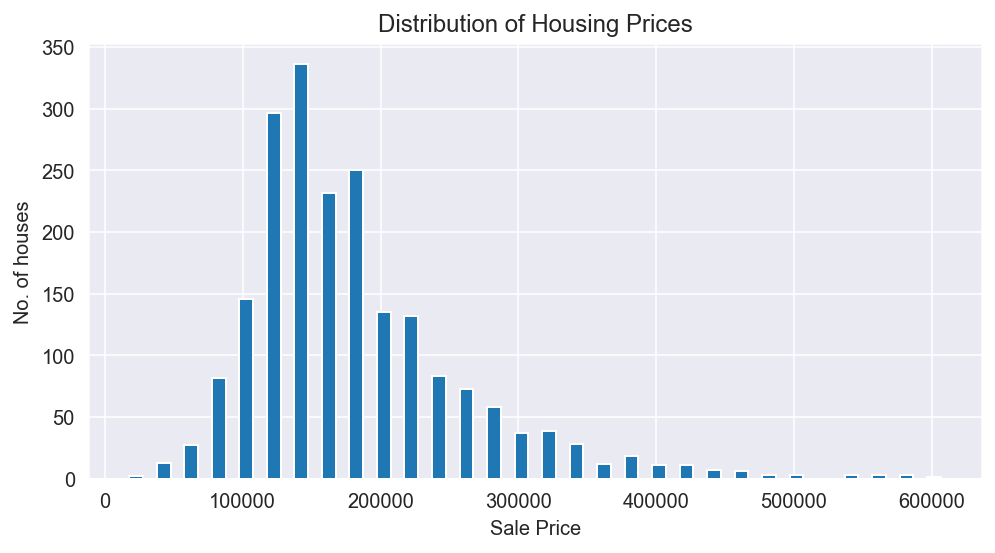

In [17]:
print(house['SalePrice'].describe())

fig, ax = plt.subplots(figsize=(8,4))
ax.hist(house['SalePrice'], bins=30, rwidth=0.5)
ax.set_title('Distribution of Housing Prices')
ax.set_xlabel('Sale Price')
ax.set_ylabel('No. of houses')
ax.grid(b=True)

#### Relationship between Continous Features and Sale Price

Based on the correlation heatmap, sale price and the following features have a high correlation (greater than 0.5):

- overallqual
- totalbsmtSF
- 1stflrSF
- grlivarea
- garagecars
- garage area

Some observed correlations between other features: 

1. very high correlation between GarageCars and GarageArea (corr coef=0.89)
2. very high correlation between YearBuilt and GarageYrBlt (corr coef =0.83) 
3. very high correlation between TotRmsAbvGr and GrLivArea (corr coef =0.81)

The features with highly correlated with sale price will explored first before exploring other features with high correlation coefficients which indicates high collinearity.

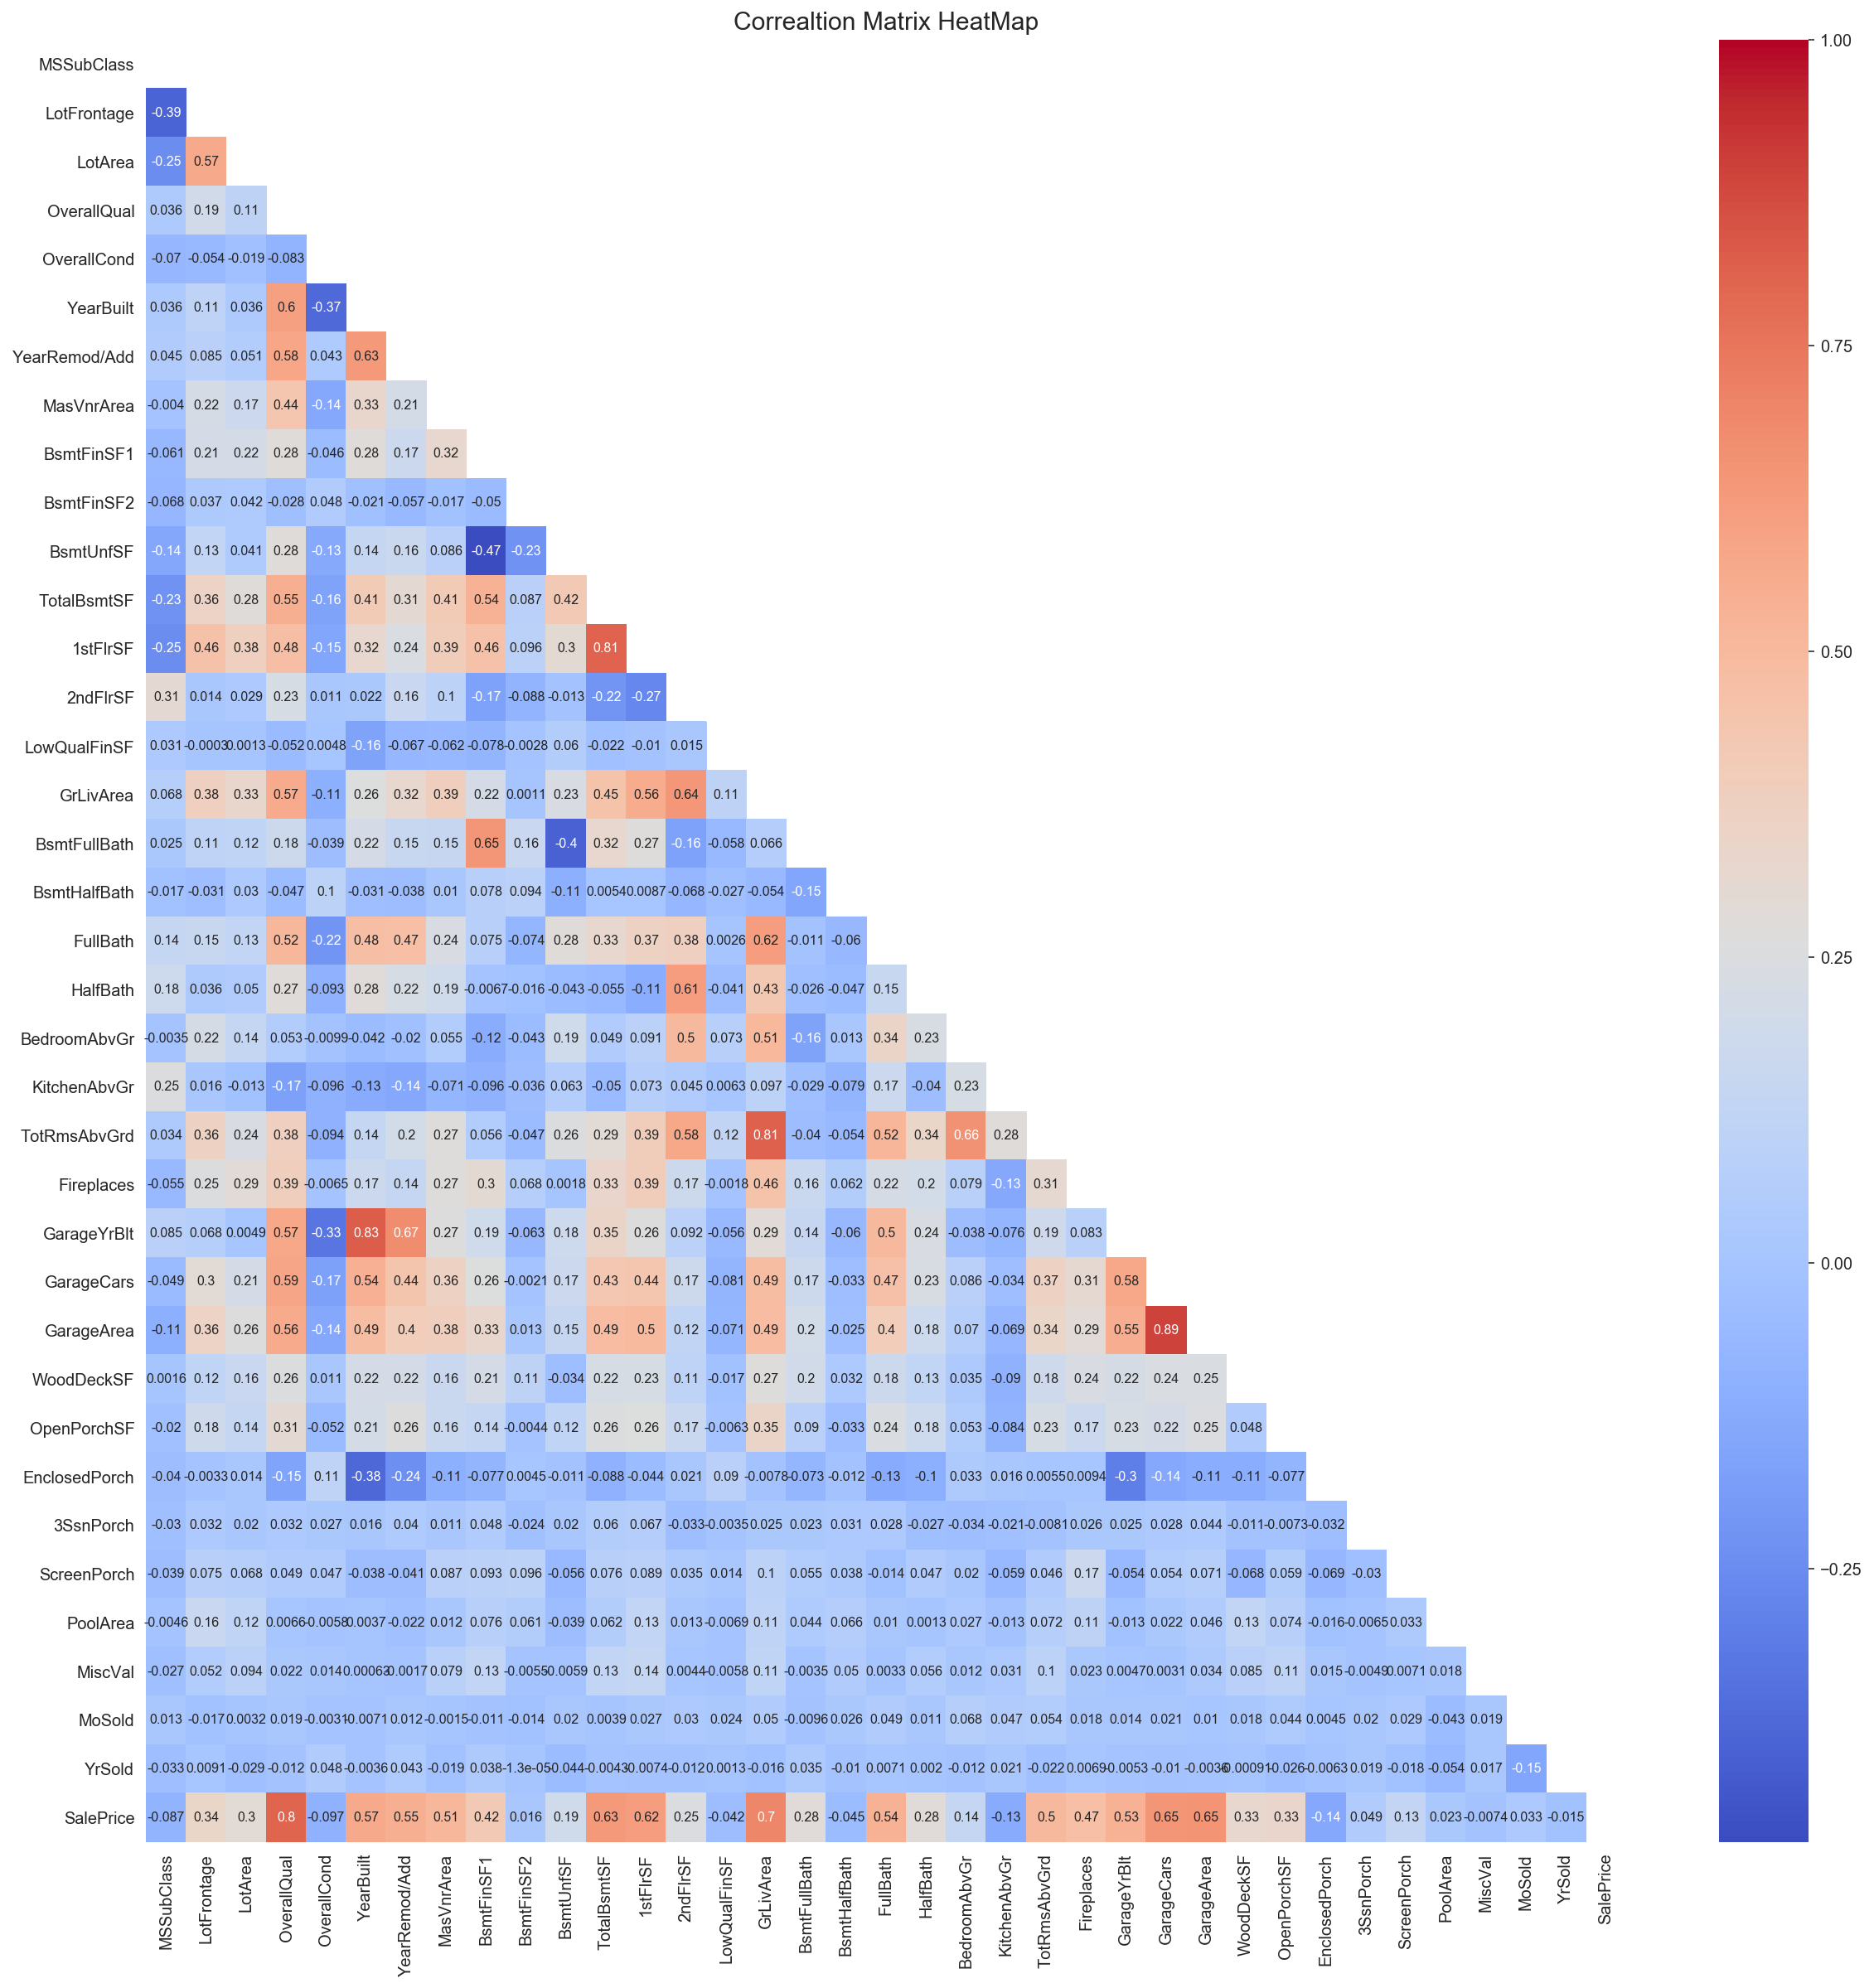

In [18]:
#correlation heatmap for continuous variables
plt.figure(figsize=(20,20))
mask = np.zeros_like(house.corr())
mask[np.triu_indices_from(mask)] = True

with sns.axes_style('white'):
    sns.heatmap(house.corr(),annot=True,mask=mask,annot_kws={"size":8},cmap='coolwarm')
plt.title("Correaltion Matrix HeatMap",fontsize=15);

In [19]:
house.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemod/Add', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'W

Observations from scatterplots: 

- Based on the scatterplot, there is a positive correlation between Sale Price and Gr Liv Area. This is expected as one will typically have to pay a higher price for larger houses (cost per sq foot). Also noticed that there are two outliers where area is > 5000 and the prices are extremely low. 
  The curve also seems to have a steeper gradient with increasing Gr Liv Area and may indicate a relationship of polynomial order
- Positive correaltion between Sale Price and Total Basement Sq Ft. This is also expected as one will typically have to pay a higher price for larger houses. Also notice that there are two outliers where area is > 5000 and the prices are low . In addition, there are houses were the basement area is zero and these could be properties with no basement
- Positive correaltion between Sale Price and Garage Area, this is also expected as one will typically have to pay a higher price for more garage space. In addition, there are houses were the garage area is zero and these could be properties with no garage. 
- Positive correlation (0.51) between Sale Price and Masonry Area
  in addition, there are a significant number of houses where masonry veneer area is zero and these could be properties with no masonry finish

In [20]:
#function to plot scatterplots
def subplot_scatter(dataframe, list_of_xcolumns, list_of_ycolumns, list_of_titles, list_of_xlabels, list_of_ylabels):
    nrows = int(np.ceil(len(list_of_xcolumns)/2)) # determine number of rows
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(15,15)) 
    ax = ax.ravel() # Ravel turns a matrix into a vector for easy iteration
#     ax[3].axis('off')
    for i, column in enumerate(list_of_xcolumns): # Gives us an index value to get into all our lists
        ax[i].scatter(dataframe[column],dataframe[list_of_ycolumns[i]]) 
        ax[i].set_title(list_of_titles[i])
        ax[i].set_xlabel(list_of_xlabels[i])
        ax[i].set_ylabel(list_of_ylabels[i])
      

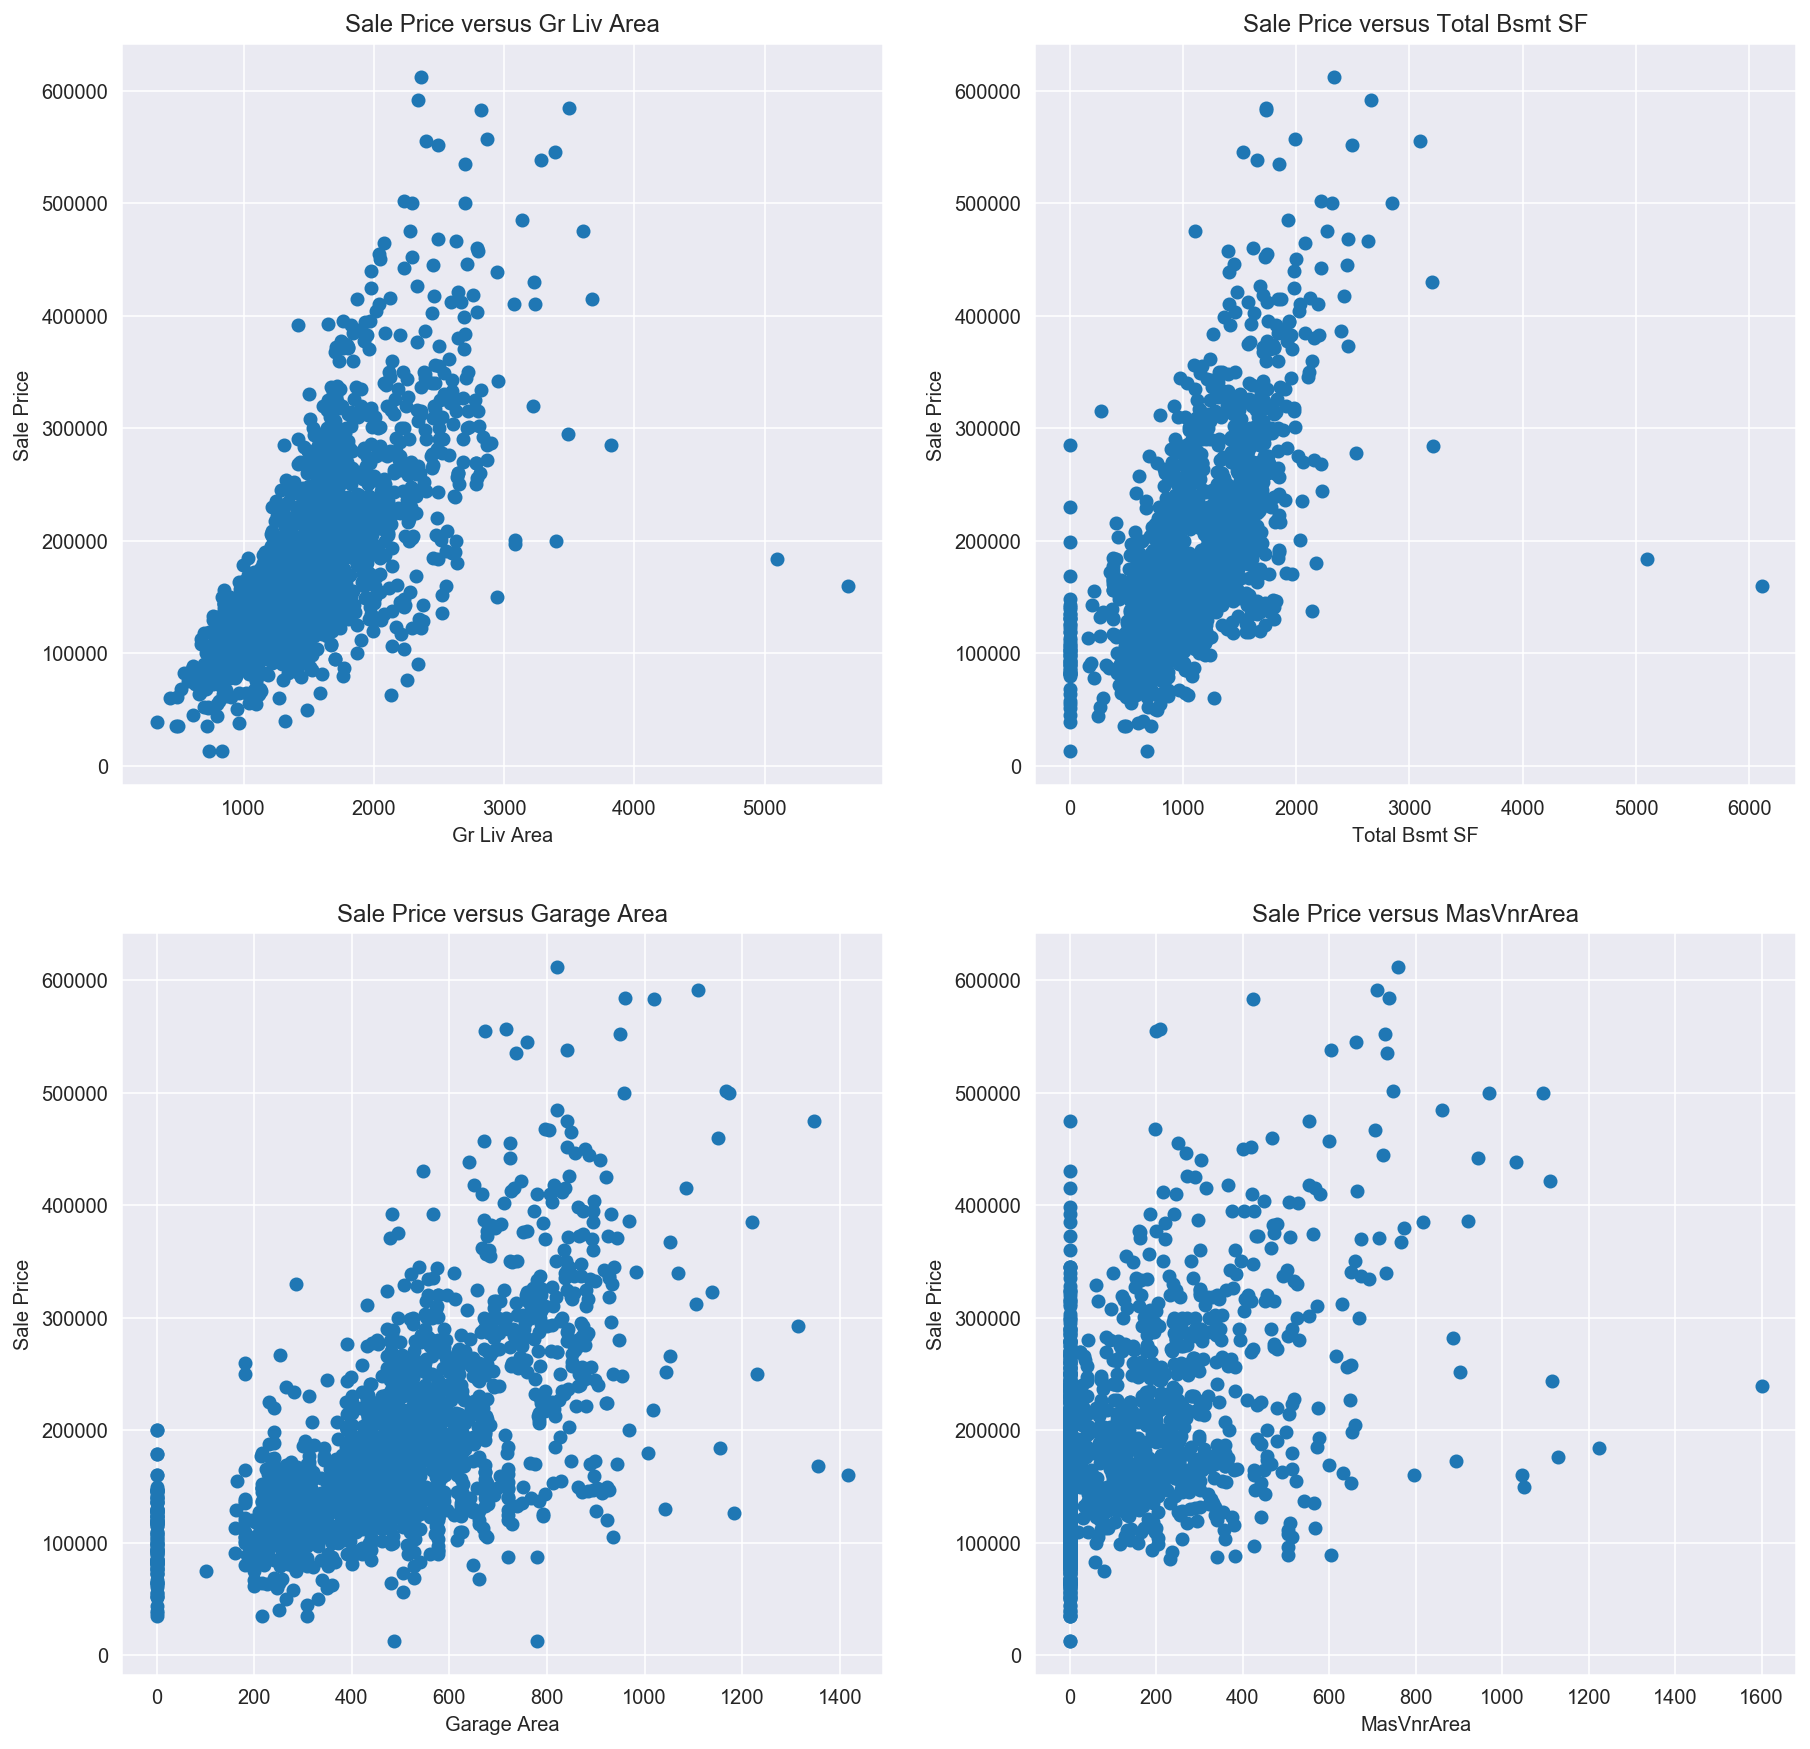

In [21]:
# Explore continuous features with a high correlation (greater than 0.5 from the heatmap) with SalePrice
# the scatter plot of SalePrice vs Gr Liv Area, SalePrice vs Total Bsmt SF and SalePrice vs Garage Area will be plotted

# Passing the columns to plot and set titles, labels below
list_of_xcolumns =['GrLivArea','TotalBsmtSF','GarageArea','MasVnrArea']
list_of_ycolumns =['SalePrice','SalePrice','SalePrice','SalePrice']
list_of_titles = ['Sale Price versus Gr Liv Area','Sale Price versus Total Bsmt SF','Sale Price versus Garage Area','Sale Price versus MasVnrArea'] 
list_of_xlabels = ['Gr Liv Area','Total Bsmt SF','Garage Area','MasVnrArea'] 
list_of_ylabels = ['Sale Price','Sale Price','Sale Price','Sale Price'] 

subplot_scatter(house, list_of_xcolumns, list_of_ycolumns, list_of_titles, list_of_xlabels, list_of_ylabels)

plt.savefig('../figure/ScatterplotCont')

In [22]:
#Recap by looking at the correlation coefficent of the features for feature selection and modelling
house.corr()['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.800207
GrLivArea        0.697038
GarageArea       0.650270
GarageCars       0.648220
TotalBsmtSF      0.628925
1stFlrSF         0.618486
YearBuilt        0.571849
YearRemod/Add    0.550370
FullBath         0.537969
GarageYrBlt      0.533922
MasVnrArea       0.512230
TotRmsAbvGrd     0.504014
Fireplaces       0.471093
BsmtFinSF1       0.423519
LotFrontage      0.341842
OpenPorchSF      0.333476
WoodDeckSF       0.326490
LotArea          0.296566
BsmtFullBath     0.283662
HalfBath         0.283001
2ndFlrSF         0.248452
BsmtUnfSF        0.190210
BedroomAbvGr     0.137067
ScreenPorch      0.134581
3SsnPorch        0.048732
MoSold           0.032735
PoolArea         0.023106
BsmtFinSF2       0.016255
MiscVal         -0.007375
YrSold          -0.015203
LowQualFinSF    -0.041594
BsmtHalfBath    -0.045328
MSSubClass      -0.087335
OverallCond     -0.097019
KitchenAbvGr    -0.125444
EnclosedPorch   -0.135656
Name: SalePrice, dtype: float64

Observations from scatterplots: 

- Based on the scatterplots below, there is a general trend the sale price increases with an increase of the discrete feature (price increase with number of rooms/area). The only exception is the KitchenAboveGr which yield a plot that is contrary to this. Upon further observation, most of the houses fall under the category of having kitchen. It may be worth eliminating this feature as the observations may not be represenative of houses with 2 or more kitchens.

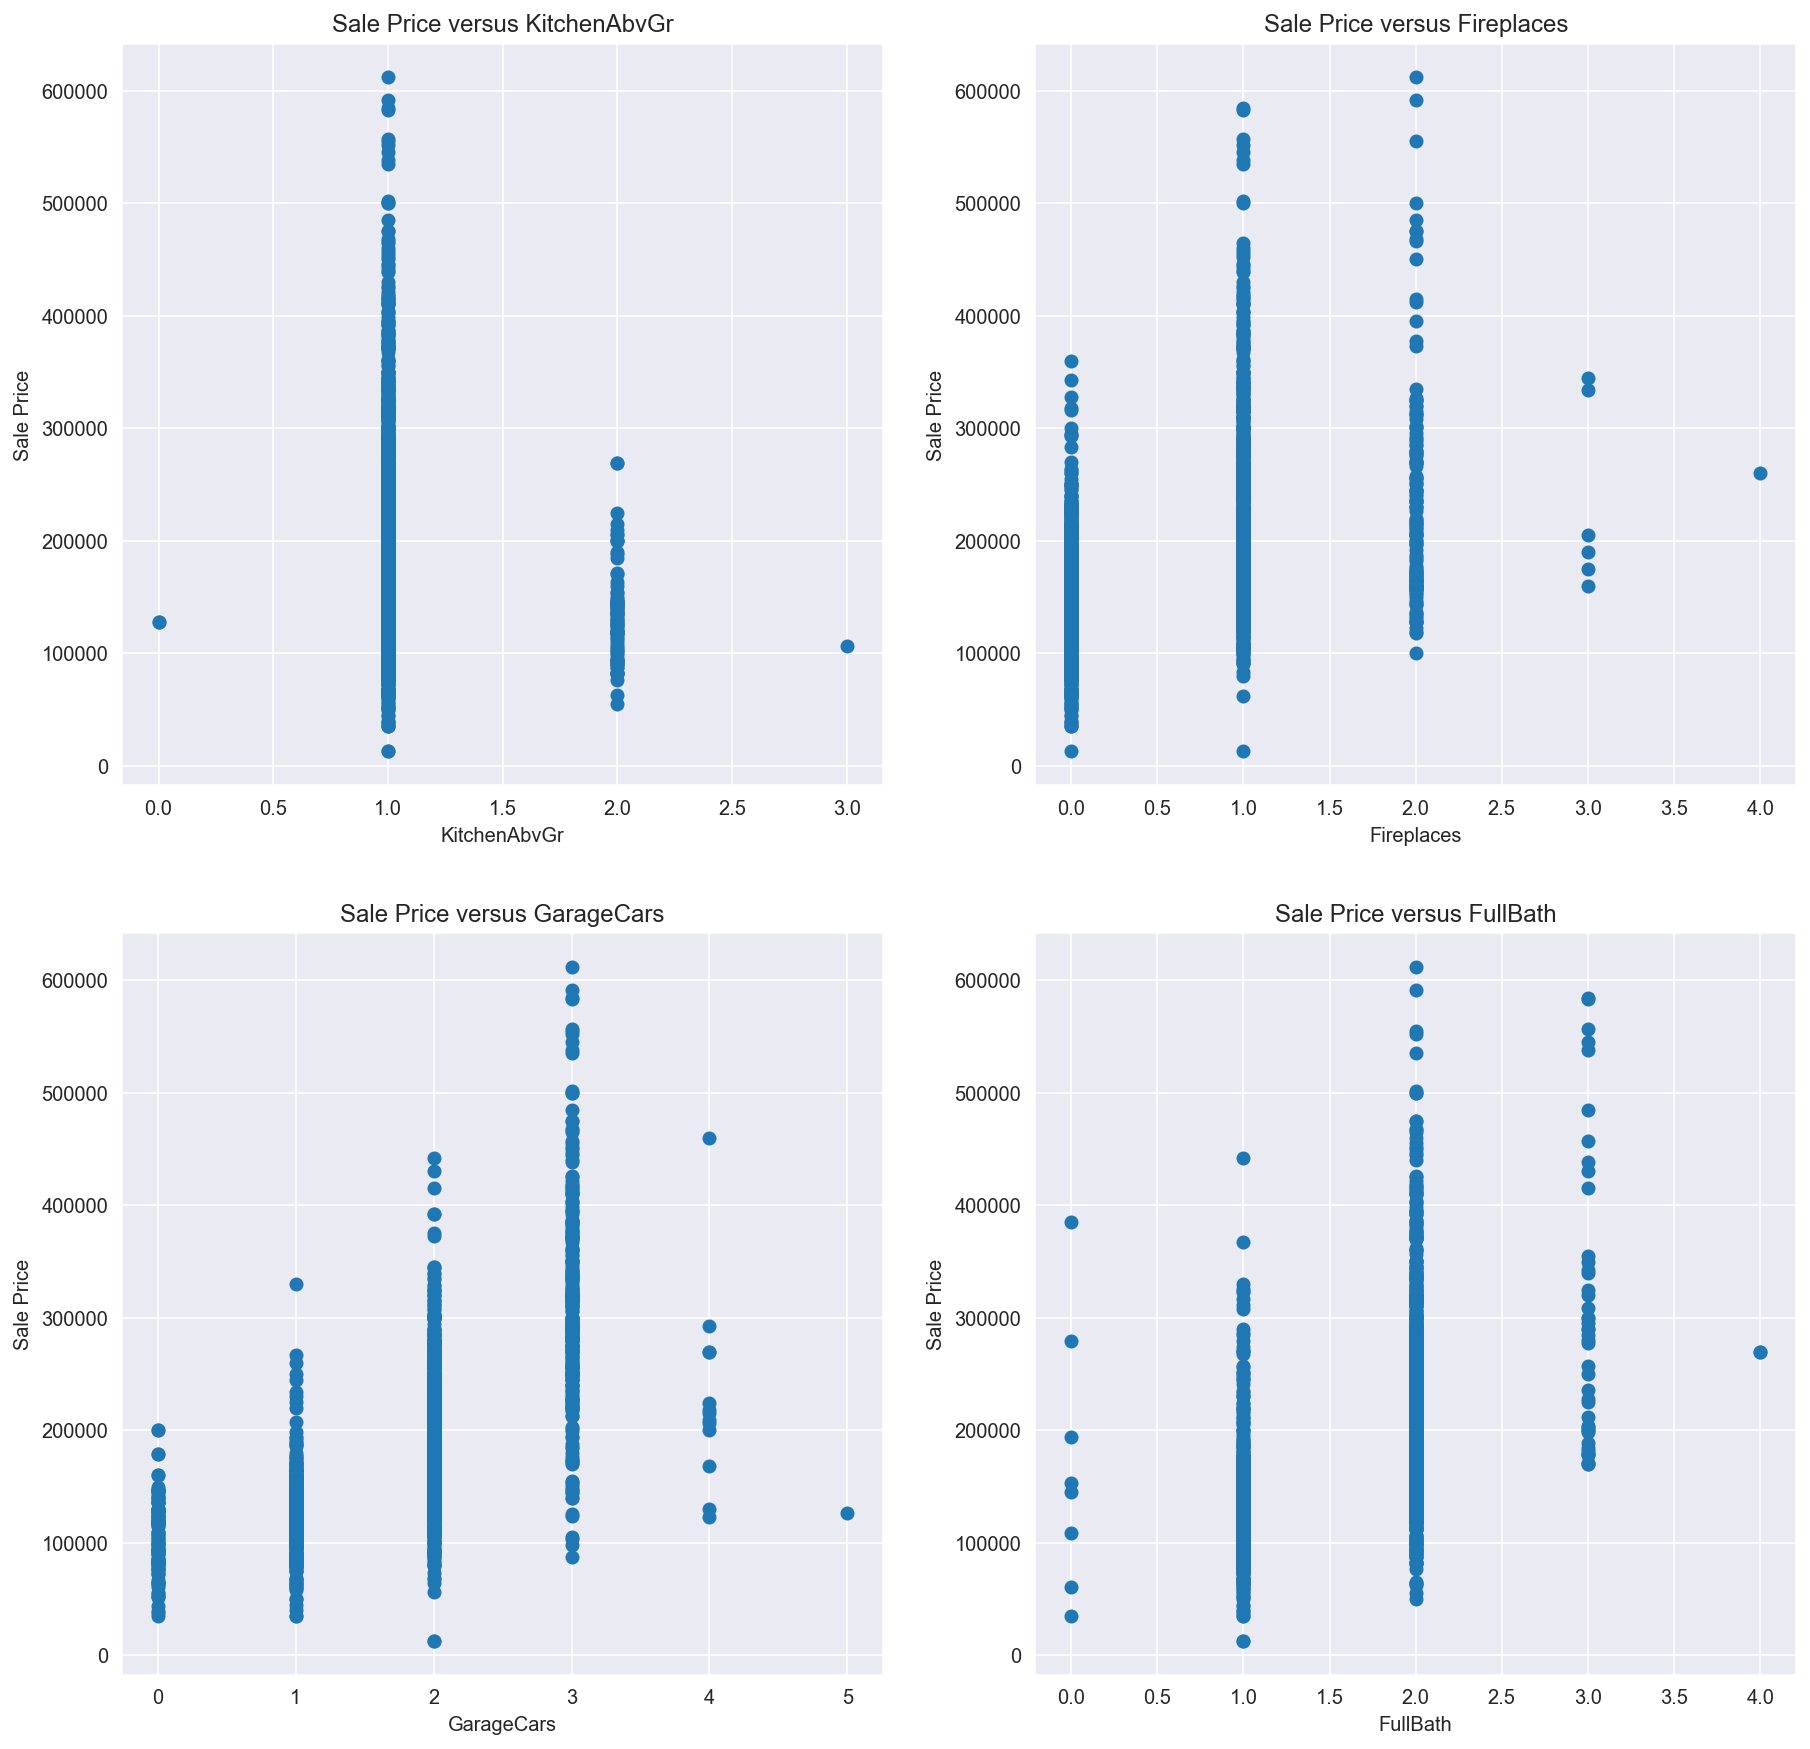

In [23]:
# Explore continuous features with a high correlation (greater than 0.5 from the heatmap) with SalePrice
# the scatter plot of SalePrice vs KitchenAbvGr, SalePrice vs Fireplaces, SalePrice vs Garage Cars and SalePrice vs Full Bath will be plotted

# Passing the columns to plot and set titles, labels below
list_of_xcolumns =['KitchenAbvGr','Fireplaces','GarageCars','FullBath']
list_of_ycolumns =['SalePrice','SalePrice','SalePrice','SalePrice']
list_of_titles = ['Sale Price versus KitchenAbvGr','Sale Price versus Fireplaces','Sale Price versus GarageCars','Sale Price versus FullBath'] 
list_of_xlabels = ['KitchenAbvGr','Fireplaces','GarageCars','FullBath'] 
list_of_ylabels = ['Sale Price','Sale Price','Sale Price','Sale Price'] 

subplot_scatter(house, list_of_xcolumns, list_of_ycolumns, list_of_titles, list_of_xlabels, list_of_ylabels)

plt.savefig('../figure/ScatterplotDiscrete')


In [24]:
#based on the above, scatter plots value counts of KitchenAbvGr and it can be seen that close to all the houses fall in 
# the category with one kitchen it may be worth eliminating this feature as it may not be useful for the model to discern 
# between sale price when the number of kitchen changes
house['KitchenAbvGr'].value_counts()

1    1960
2      88
0       2
3       1
Name: KitchenAbvGr, dtype: int64

#### Relationship between Categorical Features and Sale Price

<u>Observation for Relationship between Overall Qual and Sale Price:</u> 

There is a general trend that better overall material and finish of the house 
leads to a higher sale price as seen with the increase in median prices as quality increases . This coincides with expectations as one would be expected to pay more for higher quality finishes

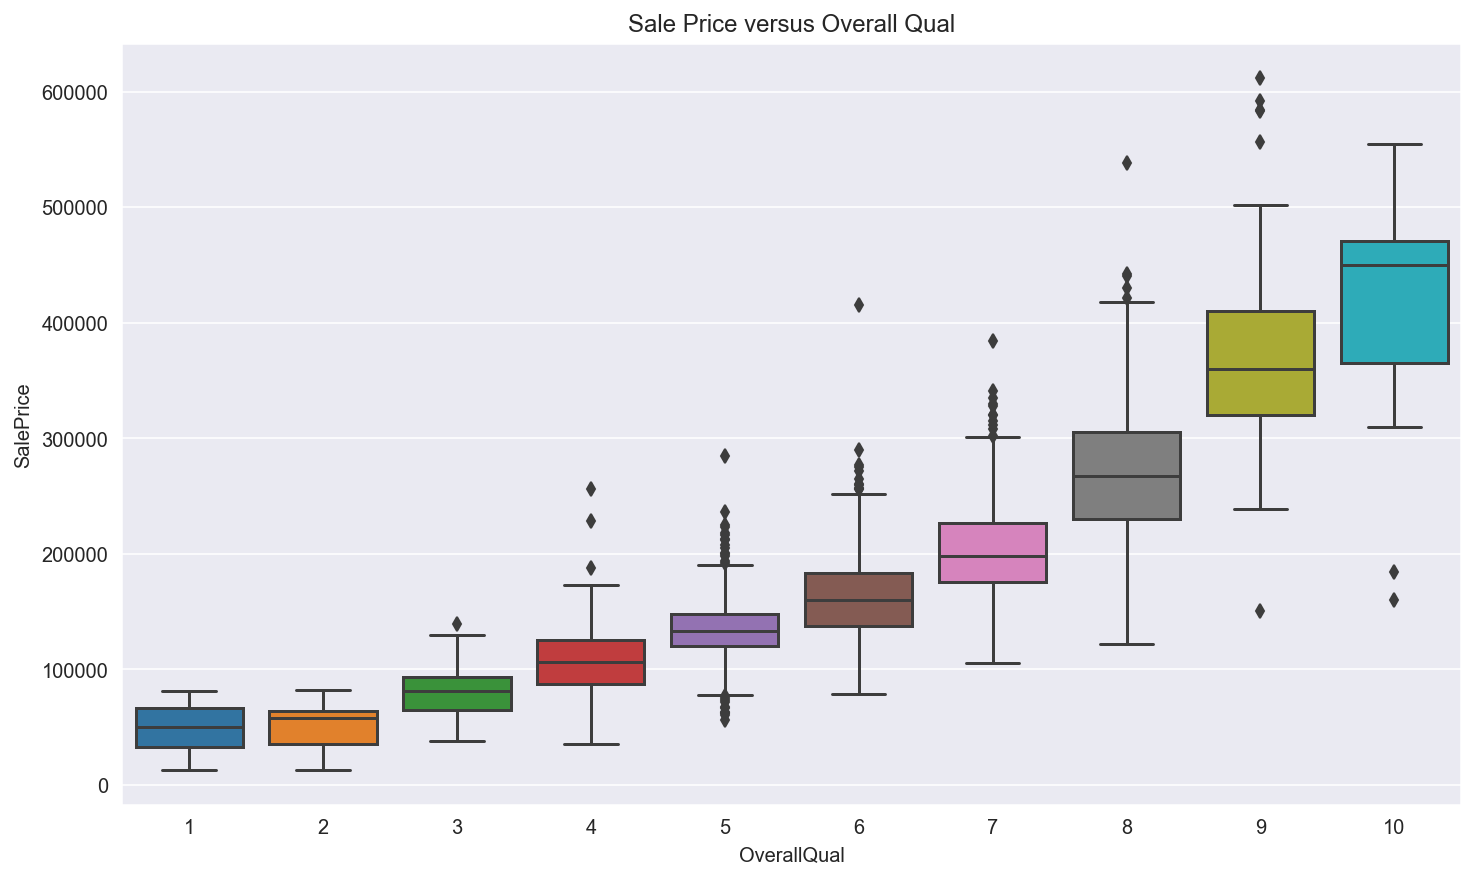

In [25]:
#categorical featues
#Relationship between overall qual and sale price 
fig, ax = plt.subplots(figsize=(12,7))
sns.boxplot(data=house, x='OverallQual',y='SalePrice')
plt.title('Sale Price versus Overall Qual');

plt.savefig('../figure/BoxplotOverallQual')


<u>Observation for Relationship between Overall Cond and Sale Price:</u> 

Observation, there is a general trend that better overall condition of the house leads to a higher sale price as seen with the increase in median prices for houses with a better condition. However when compared to overall quality, quality seems to yield a wider variance in sale price as compared to overall condition. Another observation from the boxplot, is that the average condition houses (rated 5) does not seem to follow the trend -  it has the highest median score and the largest spread of sale prices and would be worth exploring further


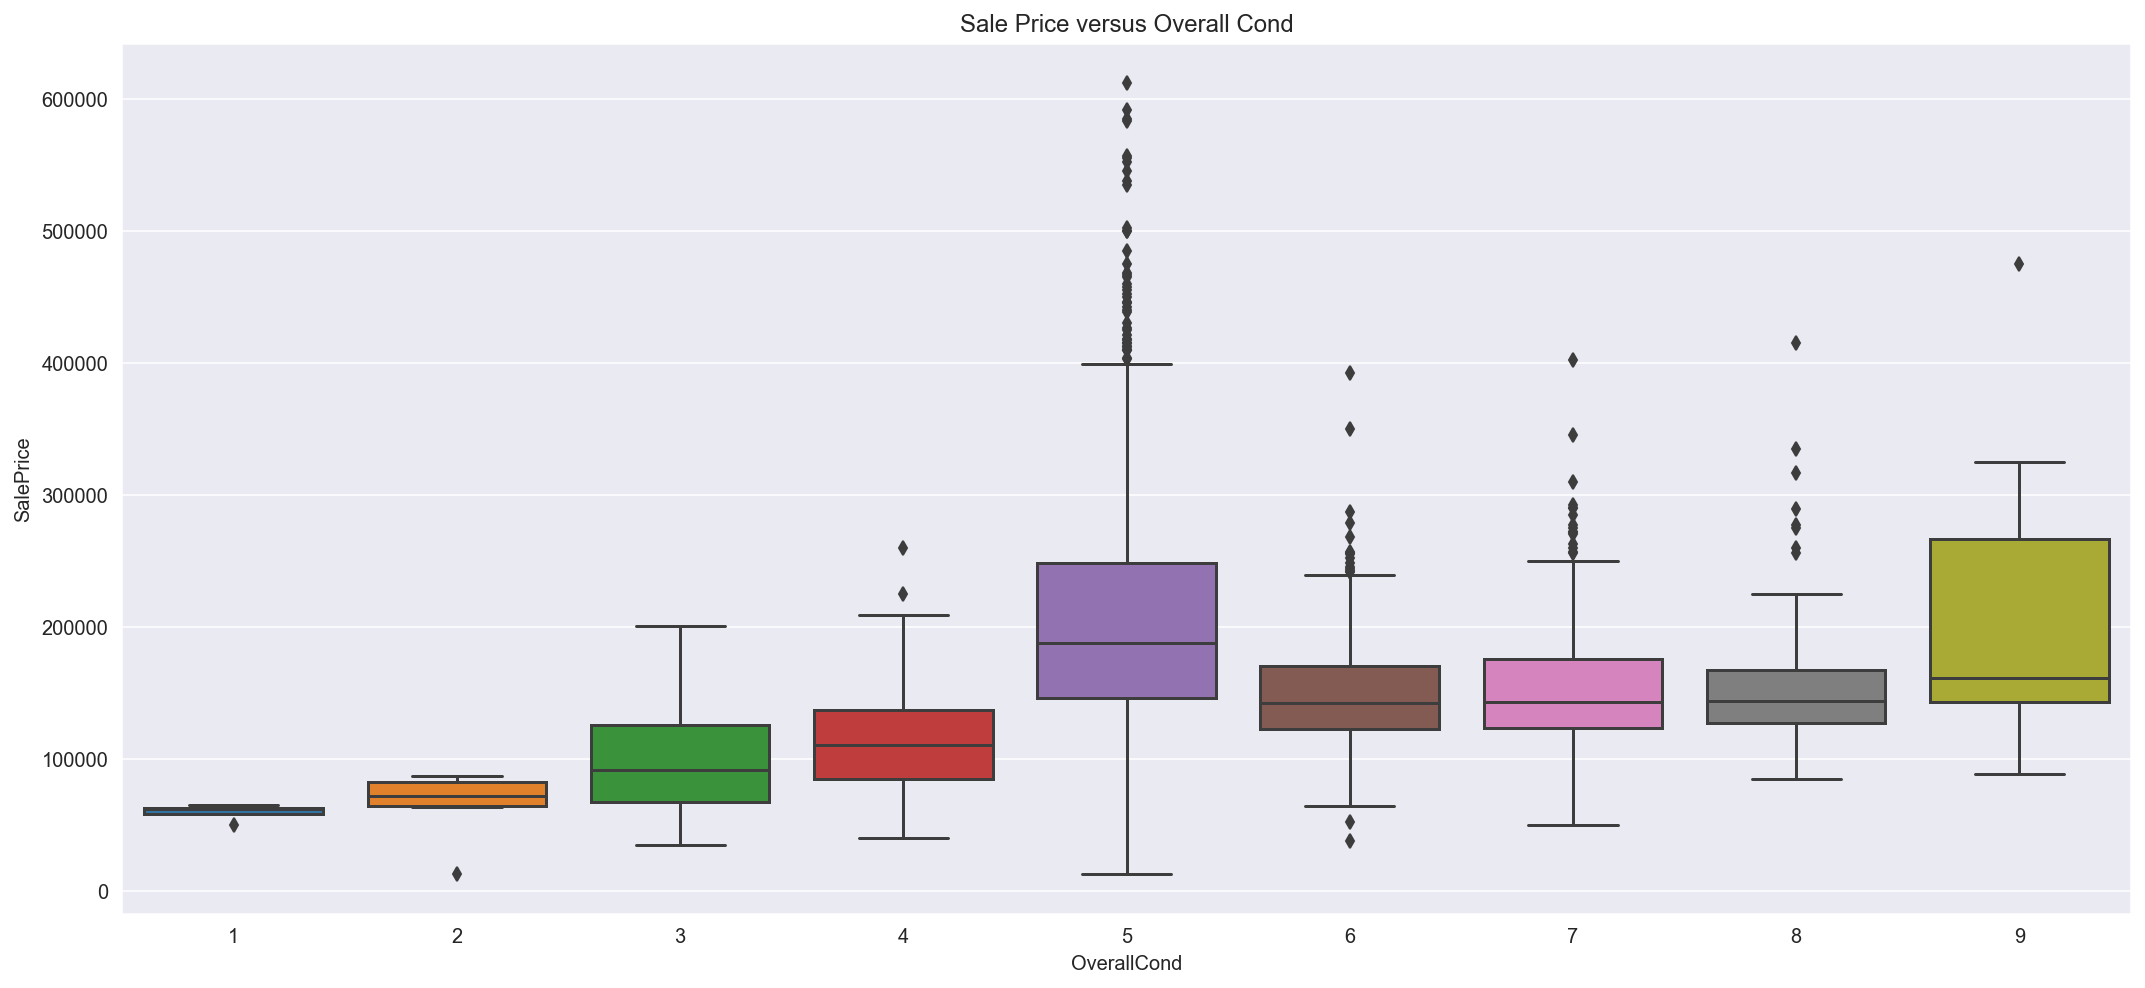

In [26]:
#categorical featues
#Relationship between overall cond and sale price 
fig, ax = plt.subplots(figsize=(18,8))
sns.boxplot(data=house, x='OverallCond',y='SalePrice' )
plt.title('Sale Price versus Overall Cond');


<u>Taking a closer look at houses rated 5 for overall cond after findings from the above boxplot:</u>

It seems like most of the houses in the data set are of average condition (rating of 5). The model may be more representative of houses with average condition of 5 and may not perform well for houses that fall in other conditions.

count    2051.000000
mean        5.562165
std         1.104497
min         1.000000
25%         5.000000
50%         5.000000
75%         6.000000
max         9.000000
Name: OverallCond, dtype: float64


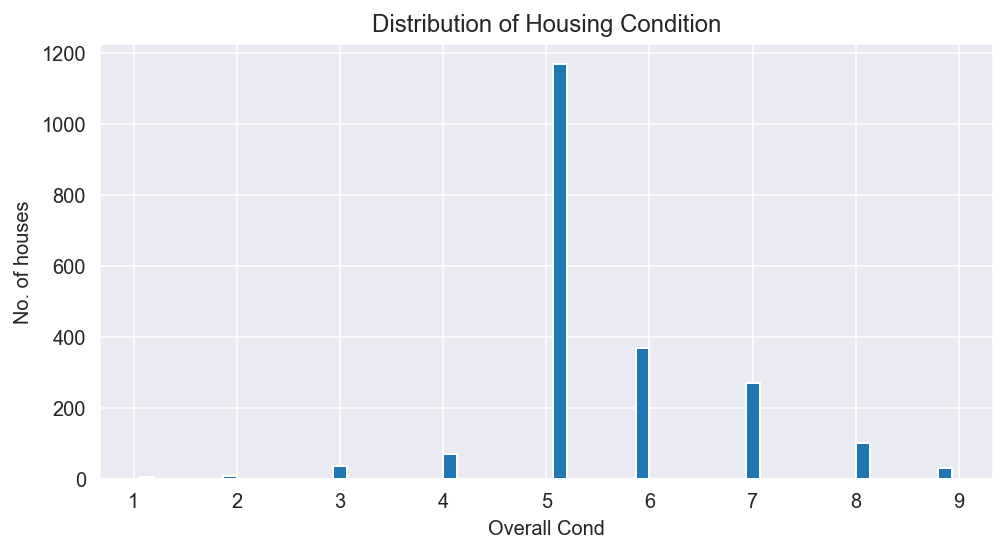

In [27]:
#Taking a closer look at houses rated 5 for overall cond after findings from the above boxplot

print(house['OverallCond'].describe())

fig, ax = plt.subplots(figsize=(8,4))
ax.hist(house['OverallCond'], bins=30, rwidth=0.5)
ax.set_title('Distribution of Housing Condition')
ax.set_xlabel('Overall Cond')
ax.set_ylabel('No. of houses')
ax.grid(b=True)


<u>Observation for Relationship between Year Built and Sale Price</u> 

There is a general trend that newer houses leads to a higher median sale price as seen with the increase in median prices for houses built under 10 years.

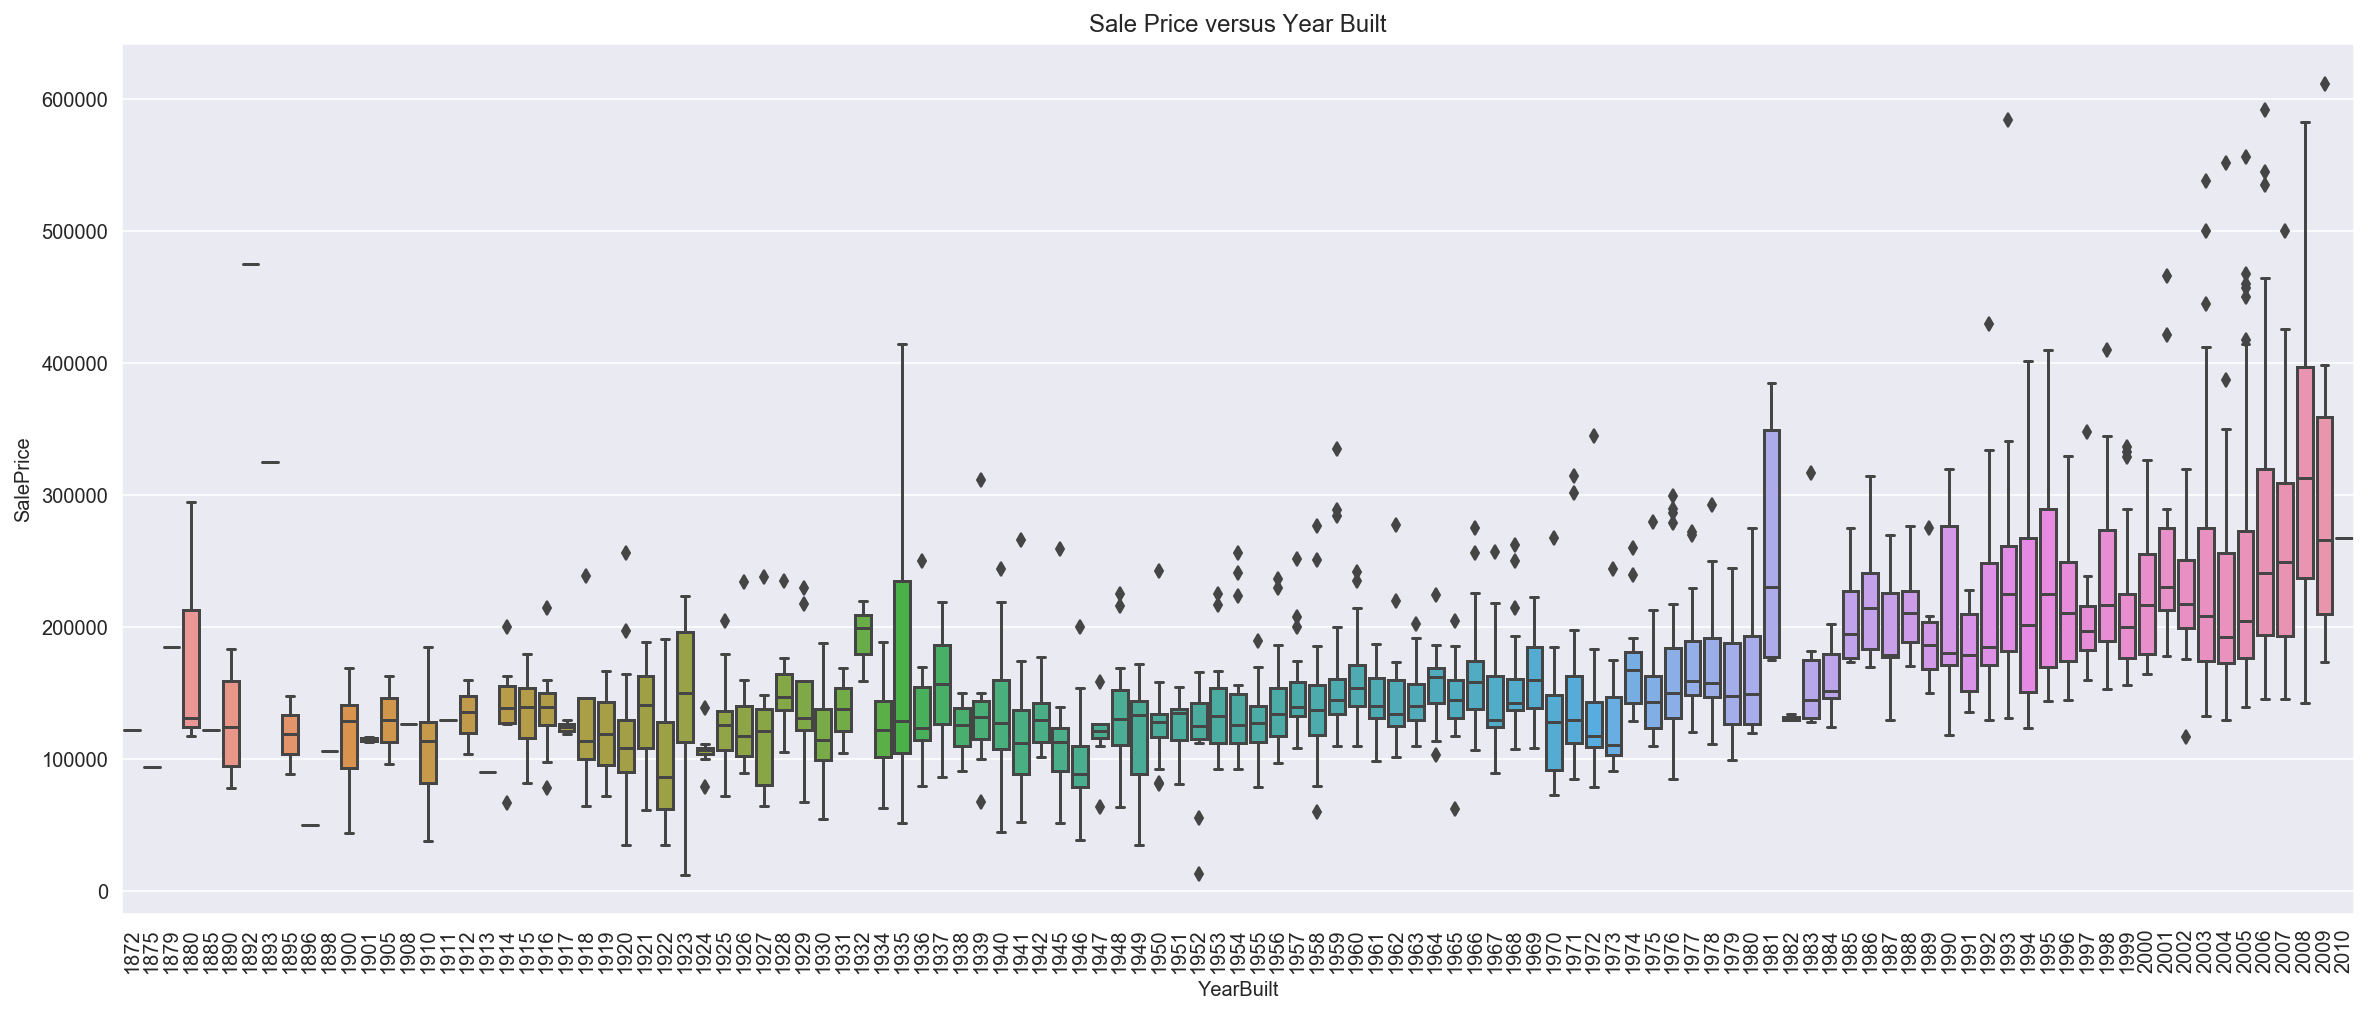

In [28]:
#looking at categorical featues
#Relationship between year built and sale price 
fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data=house, x='YearBuilt',y='SalePrice' )
plt.xticks(rotation=90)
plt.title('Sale Price versus Year Built');


<u>Observation for Relationship between MoSold and Sale Price</u> 

Observation, there is no significant trend when comparing the sales for different months. Though the month also serves as an indicator of the age of the house we will drop this feature for now and can be explored further in future studies

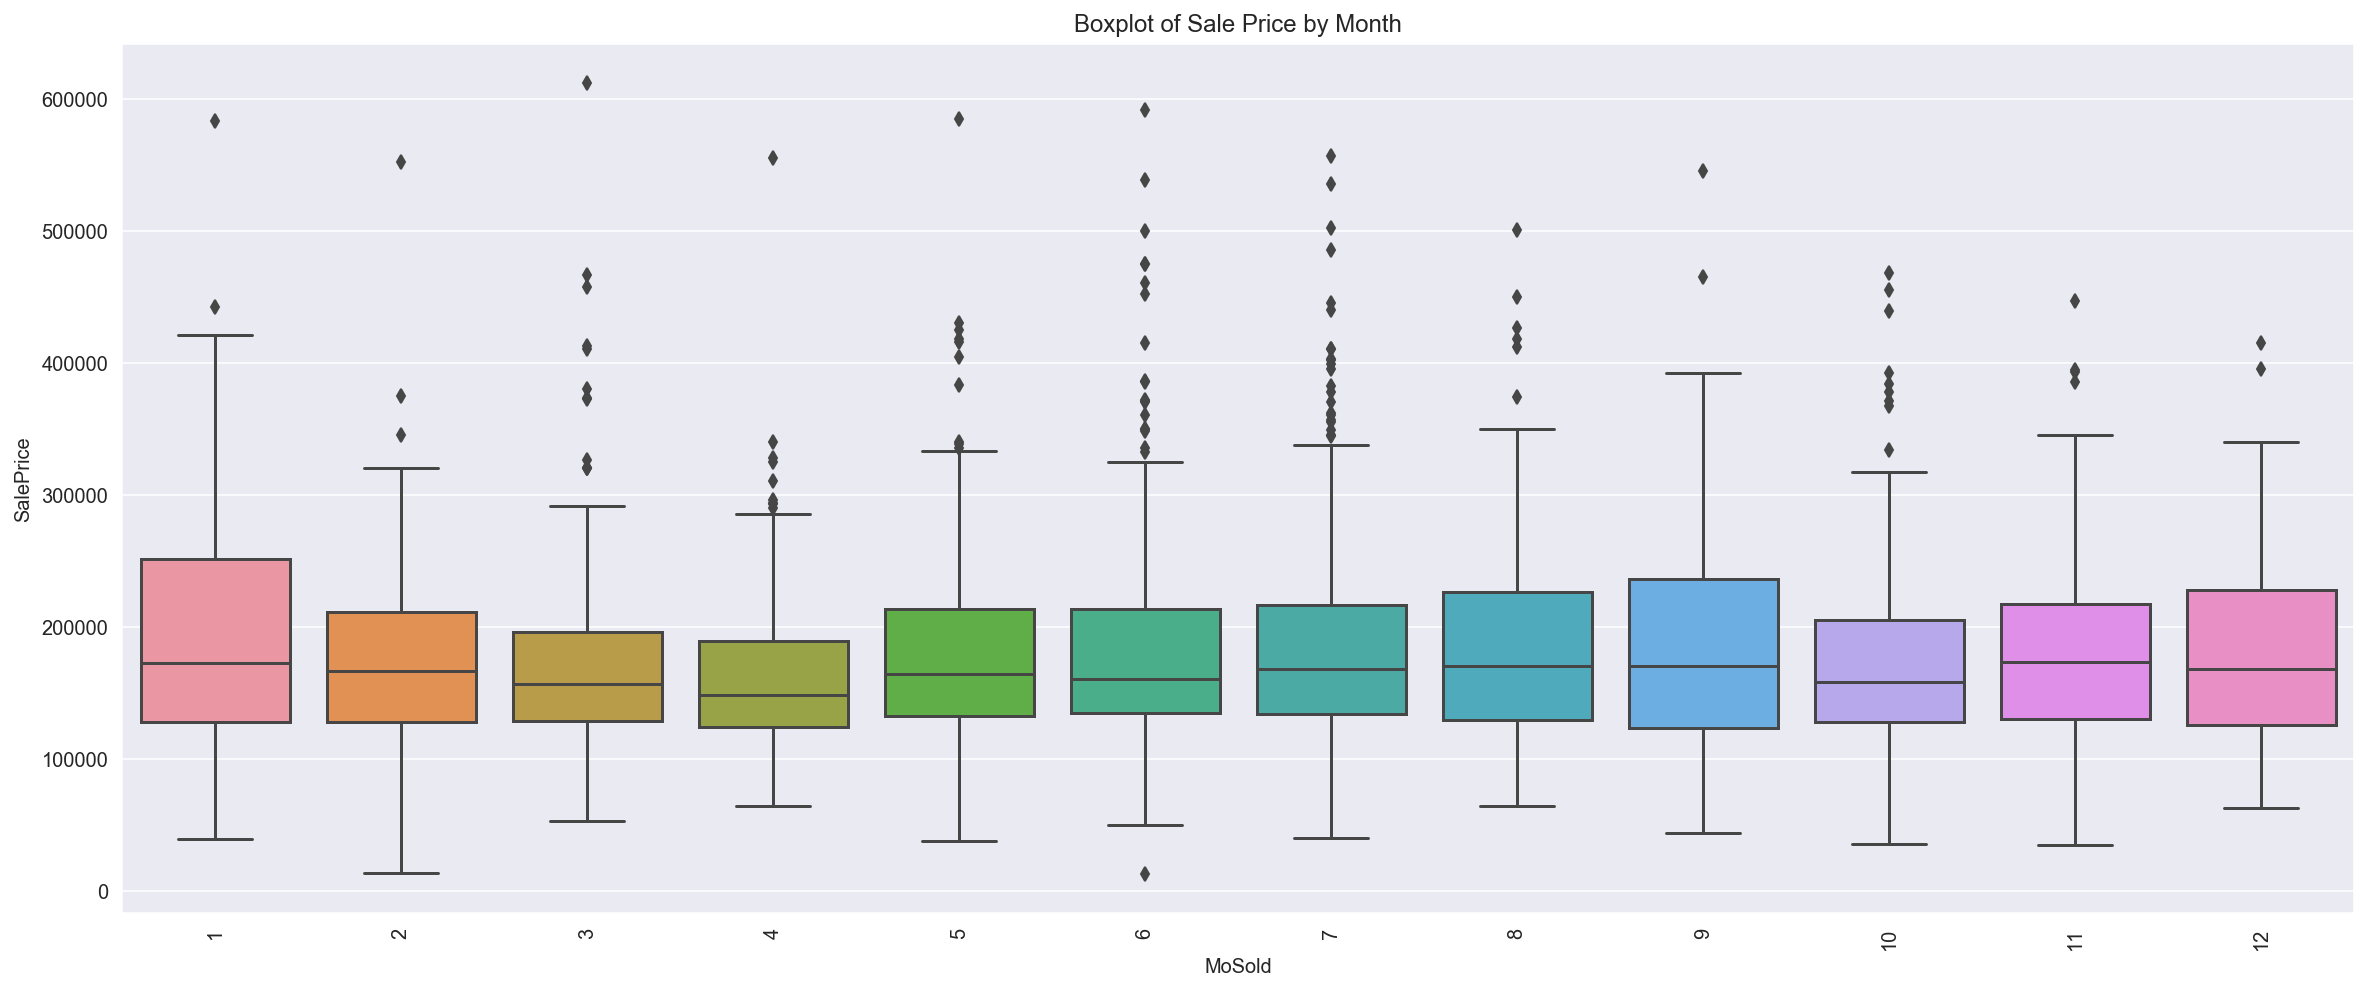

In [29]:
#looking at categorical featues
#Relationship between MoSold and sale price 
fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data=house, x='MoSold',y='SalePrice' )
plt.xticks(rotation=90)
plt.title('Boxplot of Sale Price by Month');


<u>Observation for Relationship between Neighbourhood and Sale Price</u> 

There is a trend that house in certain neighbourhoods yield a higher median sale price. This coincides with our expectations as prime areas or areas closer to city center tend to fetch higher prices
the 5 neighborhoods that stood out as having high median prices includes StoneBr, NridgHt,NoRidge with median prices of \$3000000 and above.


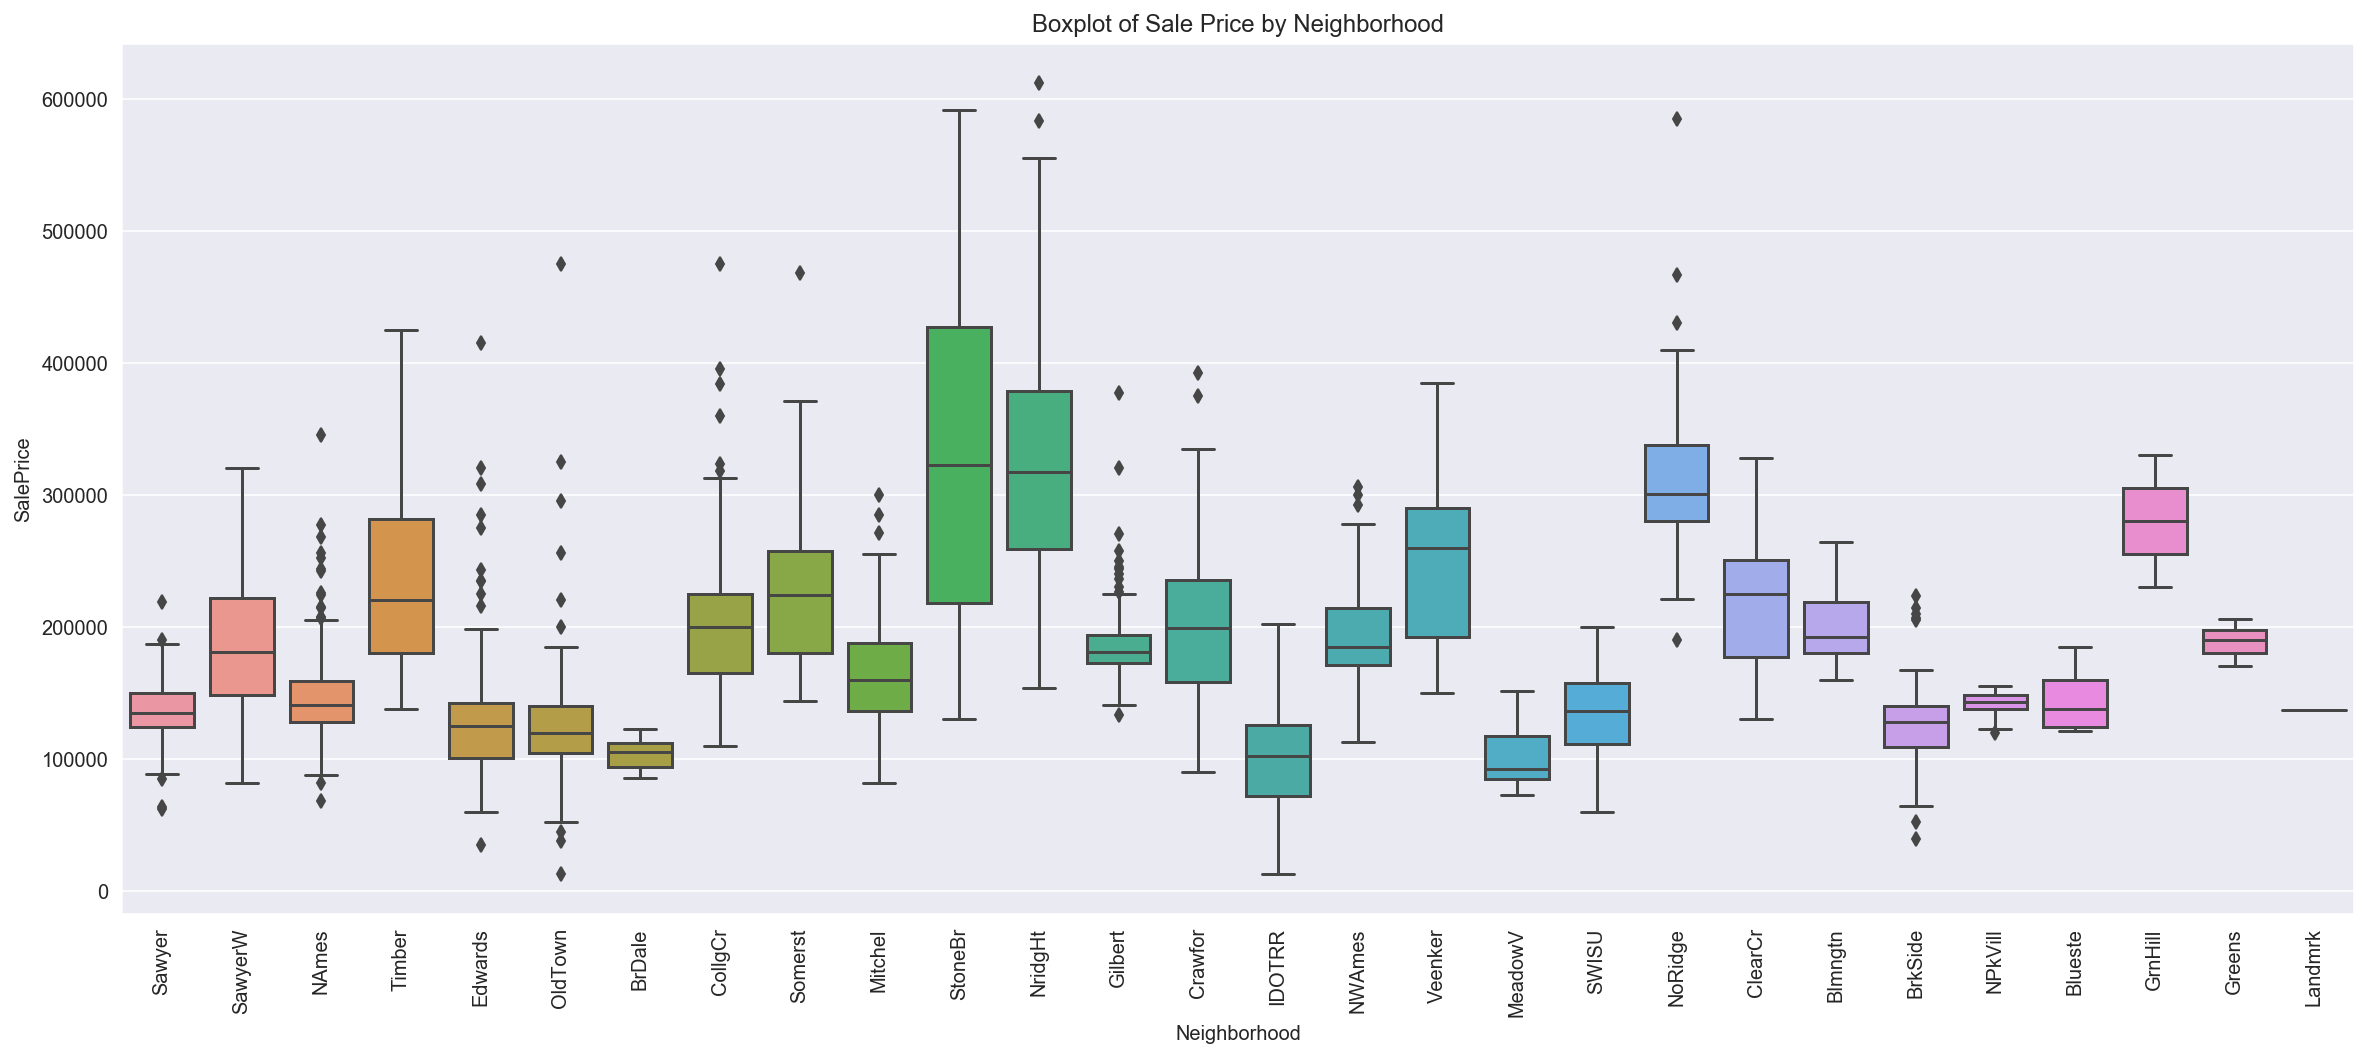

In [30]:
#looking at categorical featues
#Relationship between neighbourhood and sale price 
fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data=house, x='Neighborhood',y='SalePrice' )
plt.xticks(rotation=90)
plt.title('Boxplot of Sale Price by Neighborhood');

plt.savefig('../figure/BoxplotNeighborhood')

<u>Distribution of Houses by MS Zoning</u> 

Most of the houses fall within RL, may want to drop MSZoning.

count     2051
unique       7
top         RL
freq      1598
Name: MSZoning, dtype: object


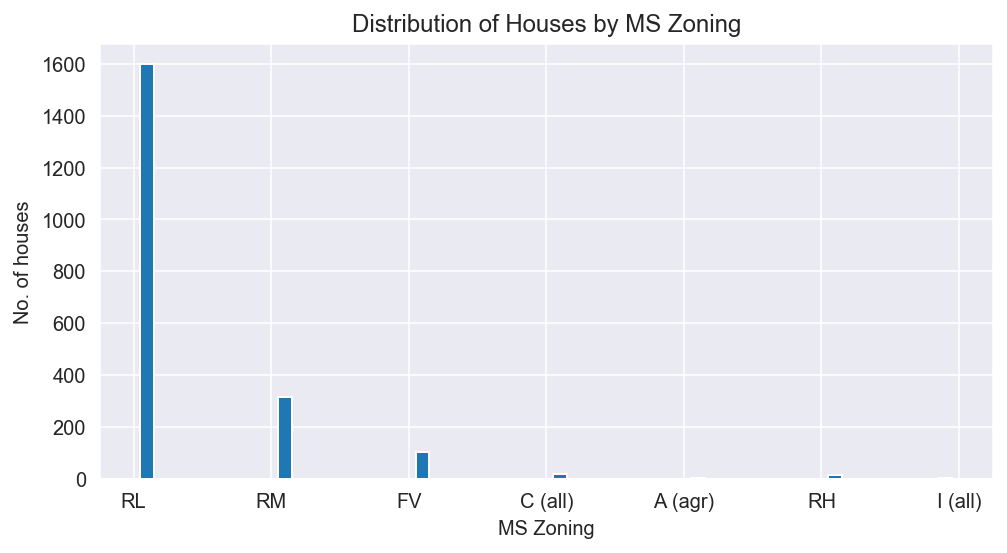

In [31]:
#Taking a closer look at distribution of houses by zoning

print(house['MSZoning'].describe())

fig, ax = plt.subplots(figsize=(8,4))
ax.hist(house['MSZoning'], bins=30, rwidth=0.5)
ax.set_title('Distribution of Houses by MS Zoning')
ax.set_xlabel('MS Zoning')
ax.set_ylabel('No. of houses')
ax.grid(b=True)


<u>Observation for Relationship between Lot Shape and Sale Price</u> 

Most of the houses fall within Reg, may want to drop Lot Shape.

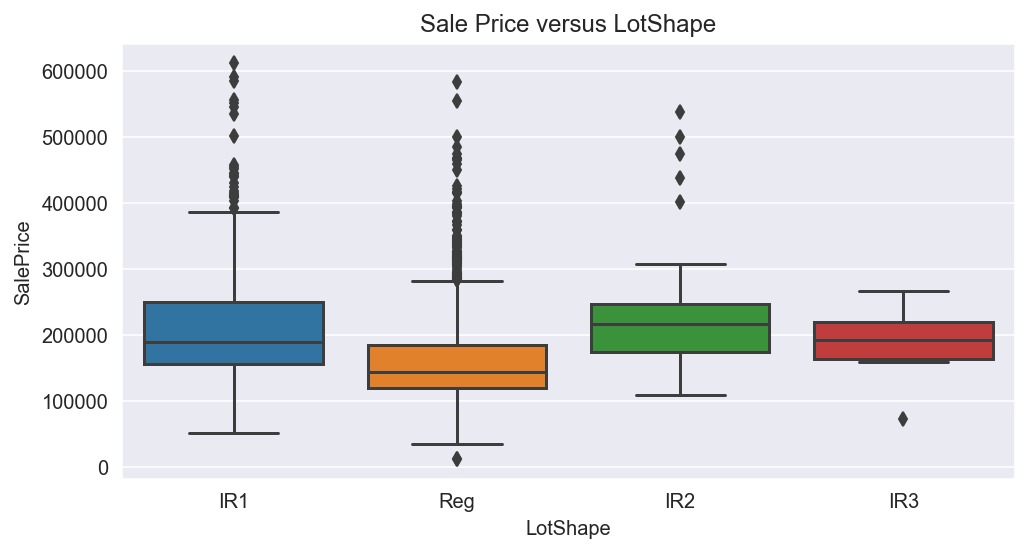

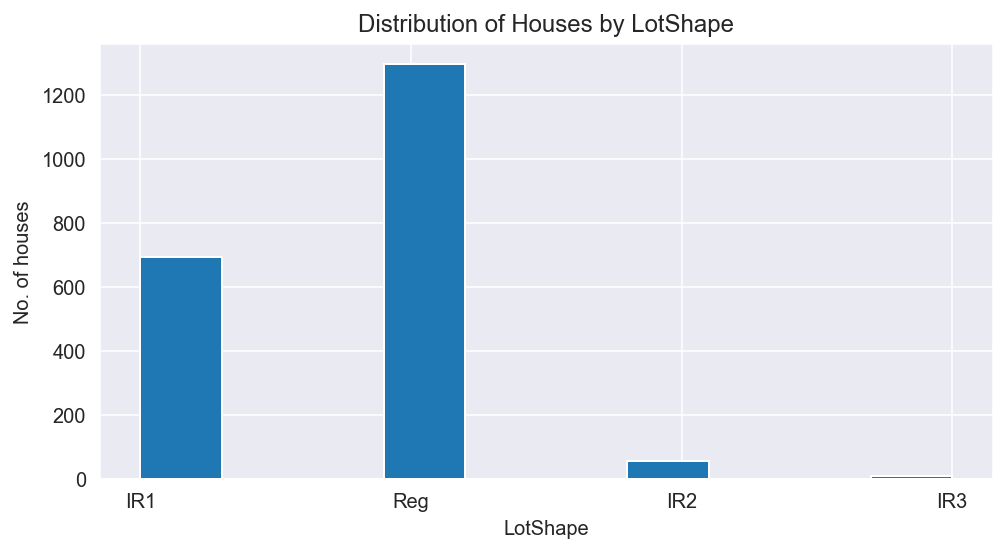

In [32]:
#Taking a closer look at distribution of houses by LotShape

fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(data=house, x='LotShape',y='SalePrice' )
plt.title('Sale Price versus LotShape');


fig, ax = plt.subplots(figsize=(8,4))
ax.hist(house['LotShape'])
ax.set_title('Distribution of Houses by LotShape')
ax.set_xlabel('LotShape')
ax.set_ylabel('No. of houses')
ax.grid(b=True)

#most of the houses fall within Reg, may want to drop LotShape

In [33]:
# The outliers that have a large area and low price will be removed from the train data set
house = house.drop(house[(house['GrLivArea']>4000) & (house['SalePrice']<300000)].index)

#### Collinearity Between Features

<u>Compare Year Built and Garage Year Built </u> 

Based on the correlation matrix earlier, there is a high correlation between year built and garage year built. Most of the Year Built and Garage Year Built are the same hence this feature will be dropped.

In [34]:
#Based on the correlation matrix earlier, there is a high correlation between year built and garage year built
same_year = [1 if house.loc[idx,'YearBuilt'] == house.loc[idx,'GarageYrBlt'] else 0 for idx in list(house.index)]
print(f'{same_year.count(1)} observations with the same Year Built and Garage Year Built')
print(f'{same_year.count(0)} observations with a different Year Built and Garage Year Built')

#comment: may want to consider including this as a feature later but will be dropped for now

#Drop Garage Yr Built
house.drop(columns = 'GarageYrBlt', inplace=True)
test.drop(columns = 'GarageYrBlt', inplace=True)
# check, train data set will have additional SalePrice column
print(house.shape)
test.shape

1562 observations with the same Year Built and Garage Year Built
487 observations with a different Year Built and Garage Year Built
(2049, 78)


(879, 77)

<u>Compare Garage Cars and Garage Year Built </u> 

Based on the correlation matrix earlier, there is a high correlation between Garage cars and Garage area. I 
will keep garage area since it has a higher corr coef (0.650) with sale price 


In [35]:
#Based on the correlation matrix earlier, there is a high correlation between Garage cars and Garage area
#will keep garage area since it has a higher corr (0.650270) with sale price 

#Drop GarageCars
house.drop(columns = 'GarageCars', inplace=True)
test.drop(columns = 'GarageCars', inplace=True)
# check
print(house.shape)
test.shape

(2049, 77)


(879, 76)

<u>Compare Gr Liv Area and Tot Rms Abv Grd </u> 

Based on the correlation matrix earlier, there is a high correlation between TotRmsAbvGrd and GrLivArea (value =0.81)
will keep GrLivArea since it has a higher corr (0.650) with sale price 


In [36]:
#Based on the correlation matrix earlier, there is a high correlation between TotRmsAbvGrd and GrLivArea (value =0.81)
#will keep GrLivArea since it has a higher corr (0.650270) with sale price 

#Drop TotRmsAbvGrd
house.drop(columns = 'TotRmsAbvGrd', inplace=True)
test.drop(columns = 'TotRmsAbvGrd', inplace=True)
# check
print(house.shape)
test.shape

(2049, 76)


(879, 75)

<u>Compare Pool QC and Pool Area </u> 

Based on count of null values, there is a significant proportion of PoolQC with null values (2042 out of 2051 entries). When doing a cross check with Pool Area, there are 2041 entries with 0 area, indicating that there is no pool. PoolQC will be dropped as there is insufficient observations for the model to make a good price estimate based on this feature.

In [37]:
#Based on count of null values, there is a significant proportion of PoolQC with null values (2042 out of 2051 entries)

print(house['PoolArea'].value_counts())

#Drop PoolQC
house.drop(columns = 'PoolQC', inplace=True)
test.drop(columns = 'PoolQC', inplace=True)
# check
print(house.shape)
test.shape

0      2041
561       1
519       1
800       1
738       1
648       1
576       1
368       1
228       1
Name: PoolArea, dtype: int64
(2049, 75)


(879, 74)

In [38]:
#Month sold is represented in numerical format which may give the impression
#that it is ordinal hence it will be replaced with first 3 characters of the month
house = house.replace({'MoSold':{1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'
                        }})
# check output
display(house.head())

# repeat for test data set
test = test.replace({'MoSold':{1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'
                        }})

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemod/Add,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SalePrice
0,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,Typ,0,NaN,Attchd,RFn,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,0,Mar,2010,WD,130500
1,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,Typ,1,TA,Attchd,RFn,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,0,Apr,2009,WD,220000
2,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,Typ,0,NaN,Detchd,Unf,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,0,Jan,2010,WD,109000
3,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,Typ,0,NaN,BuiltIn,Fin,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,0,Apr,2010,WD,174000
4,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,Typ,0,NaN,Detchd,Unf,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,0,Mar,2010,WD,138500


In [39]:
#Based on data description MS SubClass is a nominal variable with no intrinsic order, to convert from int
#to string by adding the characters 'SC'

house = house.replace({'MSSubClass':{20:'MS20',30:'MS30',40:'MS40',45:'MS45',50:'MS50',60:'MS60',70:'MS70',75:'MS75',80:'MS80',85:'MS85',90:'MS90',120:'MS120',150:'MS150',160:'MS160', 180:'MS180',190:'MS190'
                        }})
# check output
display(house.head())

# repeat for test data set
test = test.replace({'MSSubClass':{20:'MS20',30:'MS30',40:'MS40',45:'MS45',50:'MS50',60:'MS60',70:'MS70',75:'MS75',80:'MS80',85:'MS85',90:'MS90',120:'MS120',150:'MS150',160:'MS160', 180:'MS180',190:'MS190'
                        }})

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemod/Add,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SalePrice
0,MS60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,Typ,0,NaN,Attchd,RFn,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,0,Mar,2010,WD,130500
1,MS60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,Typ,1,TA,Attchd,RFn,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,0,Apr,2009,WD,220000
2,MS20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,Typ,0,NaN,Detchd,Unf,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,0,Jan,2010,WD,109000
3,MS60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,Typ,0,NaN,BuiltIn,Fin,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,0,Apr,2010,WD,174000
4,MS50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,Typ,0,NaN,Detchd,Unf,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,0,Mar,2010,WD,138500


#### Low Variance Feature Elimination

As discussed earlier, some of the categorical features tend to have a significant proportion with the same value and this may not aid the model in price predictions. In this segment, I will identify the features where 80% of the data have the same value which will be excluded from the model. With a large proportion of observations having the same value there will be less information for the model to discern why there is a difference in Sale Price.One should note that these features may still be useful for inference problems.

In [40]:
# Identifying categorical features
categorical_fea = house.select_dtypes(include =['object']).columns

print(f'There are {len(categorical_fea)} categorical features')
print('Categorical features:')
print(categorical_fea)
# filter the categorical columns, get unique values.sum().max then check variance for 0.2 and 0.8 range

There are 43 categorical features
Categorical features:
Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence',
       'MiscFeature', 'MoSold', 'SaleType'],
      dtype='object')


In [41]:
# function to find categorical features with low variance in observations 

def get_low_var(feature_list):
    low_var =[]
    for feature in feature_list:
        count_value = house[feature].value_counts(sort=True)[0]    #gets count of highest occuring value 
        count_na = house[feature].isnull().sum()                   #gets count of null values
        if count_value >= count_na:                                #determines which has the higher count 
            count = count_value
        else: 
            count = count_na
        ratio = count/house.shape[0]                               #get ratio of highest observed value to total row 
        if ratio >0.8:                                             #creates a list of features with low variance in data where >80% of the data has the same value
            low_var.append(feature)
            
    return low_var

In [42]:
# Features with low variance
drop_col = get_low_var(categorical_fea)
print(f'There are {len(get_low_var(categorical_fea))} feature(s) with low variance')
print(drop_col)

# These features will be dropped
house.drop(columns = drop_col , inplace=True)
test.drop(columns = drop_col, inplace=True)

# check 
print(house.shape)
test.shape

There are 22 feature(s) with low variance
['Street', 'Alley', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 'MiscFeature', 'SaleType']
(2049, 53)


(879, 52)

In [43]:
# Since we have dropped MiscFeature, MiscVal which is associated with the MiscFeature will also be dropped
house.drop(columns = 'MiscVal' , inplace=True)
test.drop(columns = 'MiscVal', inplace=True)

# check 
print(house.shape)
test.shape

(2049, 52)


(879, 51)

#### Deal with Null Values

Based on the data description, most of the features with NA indicates that the feature is not present for the property. As such, I will fill them with 'No' or 0 (categorical or numerical)

In [44]:
#Handle null values for features in the data description where NA indicates 
#that the feature is not present for the property

#function to take in a dataframe and return one where NA values are filled

def deal_with_na (house):
    
    #FireplaceQu NA indicates - No fireplace 
    house.loc[:,'FireplaceQu'] = house.loc[:,'FireplaceQu'].fillna('No')

    #LotFrontage refers to linear feet of street and is a continuous variable hence should be 0
    house.loc[:,'LotFrontage'] = house.loc[:,'LotFrontage'].fillna(0)

    #Garage Finish NA indicates - No garage
    house.loc[:,'GarageFinish'] = house.loc[:,'GarageFinish'].fillna('No')

    #similar for garage cond, garage qual and garagetype

    house.loc[:,'GarageType'] = house.loc[:,'GarageType'].fillna('No')

    #BsmtExposure Finish NA indicates - No basement
    house.loc[:,'BsmtExposure'] = house.loc[:,'BsmtExposure'].fillna('None')

    #similar for bsmtfin type 2, bsmtfin type 1, bsmtcond and bsmtqual

    house.loc[:,'BsmtFinType1'] = house.loc[:,'BsmtFinType1'].fillna('No')
    house.loc[:,'BsmtQual'] = house.loc[:,'BsmtQual'].fillna('No')

    #MasVnrType NA indicates - None
    house.loc[:,'MasVnrType'] = house.loc[:,'MasVnrType'].fillna('No')

    #MasVnrArea NA should be 0 since it is a continous variable 
    house.loc[:,'MasVnrArea'] = house.loc[:,'MasVnrArea'].fillna(0)

    #BsmtFullBath NA indicates - 0 bath
    house.loc[:,'BsmtFullBath'] = house.loc[:,'BsmtFullBath'].fillna(0)

    #BsmtHalfBath NA indicates - 0 bath
    house.loc[:,'BsmtHalfBath'] = house.loc[:,'BsmtHalfBath'].fillna(0)

    #GarageArea NA indicates - 0 since no garage
    house.loc[:,'GarageArea'] = house.loc[:,'GarageArea'].fillna(0)

    #TotalBsmtSF NA indicates - 0 since no basement
    house.loc[:,'TotalBsmtSF'] = house.loc[:,'TotalBsmtSF'].fillna(0)

    #BsmtUnfSF NA indicates - 0 since no basement
    house.loc[:,'BsmtUnfSF'] = house.loc[:,'BsmtUnfSF'].fillna(0)

    #BsmtFinSF2 NA indicates - 0 since no basement
    house.loc[:,'BsmtFinSF2'] = house.loc[:,'BsmtFinSF2'].fillna(0)

    #BsmtFinSF1 NA indicates - 0 since no basement
    house.loc[:,'BsmtFinSF1'] = house.loc[:,'BsmtFinSF1'].fillna(0)

    return house 

In [45]:
house = deal_with_na(house)
test = deal_with_na(test)

In [46]:
# checking for null values and sort in descending order
house.isnull().sum().sort_values(ascending=False)
# there are no more null values

SalePrice        0
YrSold           0
BsmtFinSF2       0
BsmtFinSF1       0
BsmtFinType1     0
BsmtExposure     0
BsmtQual         0
Foundation       0
ExterQual        0
MasVnrArea       0
MasVnrType       0
Exterior2nd      0
Exterior1st      0
RoofStyle        0
YearRemod/Add    0
YearBuilt        0
OverallCond      0
OverallQual      0
HouseStyle       0
Neighborhood     0
LotConfig        0
LotShape         0
LotArea          0
LotFrontage      0
MSZoning         0
BsmtUnfSF        0
TotalBsmtSF      0
HeatingQC        0
FireplaceQu      0
MoSold           0
PoolArea         0
ScreenPorch      0
3SsnPorch        0
EnclosedPorch    0
OpenPorchSF      0
WoodDeckSF       0
GarageArea       0
GarageFinish     0
GarageType       0
Fireplaces       0
1stFlrSF         0
KitchenQual      0
KitchenAbvGr     0
BedroomAbvGr     0
HalfBath         0
FullBath         0
BsmtHalfBath     0
BsmtFullBath     0
GrLivArea        0
LowQualFinSF     0
2ndFlrSF         0
MSSubClass       0
dtype: int64

#### Encoding Ordinal Features

Out of the ordinal features only OverallCond and OverallQual are represented in numeric form,
the remaining ordinal features shall be converted to numeric.

In [47]:
#for LotShape
categories = pd.Categorical(house['LotShape'],
categories =['IR3', 'IR2', 'IR1','Reg'], ordered=True)

labels, unique = pd.factorize(categories, sort=True)
house['LotShape'] = labels 

# check
# np.unique(house['LotShape'])

#for test set
categories = pd.Categorical(test['LotShape'],
categories =['IR3', 'IR2', 'IR1','Reg'], ordered=True)

labels, unique = pd.factorize(categories, sort=True)
test['LotShape'] = labels 



In [48]:
#converting the Ordinal features to numeric
#for ExterQual 
categories = pd.Categorical(house['ExterQual'],
categories =['Po', 'Fa', 'TA','Gd','Ex'], ordered=True)

labels, unique = pd.factorize(categories, sort=True)
house['ExterQual']= labels 

# check
# np.unique(house['ExterQual'])

#for test
categories = pd.Categorical(test['ExterQual'],
categories =['Po', 'Fa', 'TA','Gd','Ex'], ordered=True)

labels, unique = pd.factorize(categories, sort=True)
test['ExterQual']= labels 


In [49]:
#converting the Ordinal features to numeric
#for BsmtQual
categories = pd.Categorical(house['BsmtQual'],
categories =['No','Po', 'Fa', 'TA','Gd','Ex'], ordered=True)

labels, unique = pd.factorize(categories, sort=True)
house['BsmtQual']= labels 

# check
# np.unique(house['BsmtQual'])

#for test
categories = pd.Categorical(test['BsmtQual'],
categories =['No','Po', 'Fa', 'TA','Gd','Ex'], ordered=True)

labels, unique = pd.factorize(categories, sort=True)
test['BsmtQual']= labels 


In [50]:
#converting the Ordinal features to numeric
#for BsmtExposure
categories = pd.Categorical(house['BsmtExposure'],
categories =['None','No','Mn','Av','Gd'], ordered=True)

labels, unique = pd.factorize(categories, sort=True)
house['BsmtExposure']= labels 

# check
# np.unique(house['BsmtExposure'])

#for test
categories = pd.Categorical(test['BsmtExposure'],
categories =['None','No','Mn','Av','Gd'], ordered=True)

labels, unique = pd.factorize(categories, sort=True)
test['BsmtExposure']= labels 

In [51]:
#converting the Ordinal features to numeric
#for BsmtFinType1
categories = pd.Categorical(house['BsmtFinType1'],
categories =['No','Unf','LwQ','Rec','BLQ','ALQ','GLQ'], ordered=True)

labels, unique = pd.factorize(categories, sort=True)
house['BsmtFinType1']= labels 

# check
# np.unique(house['BsmtFinType1'])

#for test
categories = pd.Categorical(test['BsmtFinType1'],
categories =['No','Unf','LwQ','Rec','BLQ','ALQ','GLQ'], ordered=True)

labels, unique = pd.factorize(categories, sort=True)
test['BsmtFinType1']= labels 


In [52]:
#converting the Ordinal features to numeric
#for HeatingQC
categories = pd.Categorical(house['HeatingQC'],
categories =['Po', 'Fa', 'TA','Gd','Ex'], ordered=True)

labels, unique = pd.factorize(categories, sort=True)
house['HeatingQC']= labels 

# check
# np.unique(house['HeatingQC'])

#for test
categories = pd.Categorical(test['HeatingQC'],
categories =['Po', 'Fa', 'TA','Gd','Ex'], ordered=True)

labels, unique = pd.factorize(categories, sort=True)
test['HeatingQC']= labels 


In [53]:
#converting the Ordinal features to numeric
#for KitchenQual
categories = pd.Categorical(house['KitchenQual'],
categories =['Po', 'Fa', 'TA','Gd','Ex'], ordered=True)

labels, unique = pd.factorize(categories, sort=True)
house['KitchenQual']= labels 

# check
# np.unique(house['KitchenQual'])

#for test
categories = pd.Categorical(test['KitchenQual'],
categories =['Po', 'Fa', 'TA','Gd','Ex'], ordered=True)

labels, unique = pd.factorize(categories, sort=True)
test['KitchenQual']= labels 

In [54]:
#converting the Ordinal features to numeric
#for FireplaceQu
categories = pd.Categorical(house['FireplaceQu'],
categories =['No','Po', 'Fa', 'TA','Gd','Ex'], ordered=True)

labels, unique = pd.factorize(categories, sort=True)
house['FireplaceQu']= labels 

# check
# np.unique(house['FireplaceQu'])

#for test
categories = pd.Categorical(test['FireplaceQu'],
categories =['No','Po', 'Fa', 'TA','Gd','Ex'], ordered=True)

labels, unique = pd.factorize(categories, sort=True)
test['FireplaceQu']= labels 


In [55]:
#converting the Ordinal features to numeric
#for GarageFinish
categories = pd.Categorical(house['GarageFinish'],
categories =['No','Unf', 'RFn', 'Fin'], ordered=True)

labels, unique = pd.factorize(categories, sort=True)
house['GarageFinish']= labels 

# check
# np.unique(house['GarageFinish'])

#for GarageFinish
categories = pd.Categorical(test['GarageFinish'],
categories =['No','Unf', 'RFn', 'Fin'], ordered=True)

labels, unique = pd.factorize(categories, sort=True)
test['GarageFinish']= labels 

#### Explore features after Filling with NA and Encoding Ordinal Features

After dealing with null values and ordinal features, we shall take a look at some features that can be dropped.

<u>Compare Total Bsmt SF against sum of Bsmt Fin SF1, Bsmt Fin SF2 and Bsmt Unf SF </u> 

TotalBsmtSF is the sum of Bsmt Fin SF1, Bsmt Fin SF2 and Bsmt Unf SF hence i will only retain TotalBsmtSF which has the highest correlation to SalePrice

In [56]:
# check if TotalBsmtSF is the sum of BsmtFinSF1, BsmtFinSF2 and BsmtUnfSF
house['sum_bsmt']= house['BsmtFinSF1'] + house['BsmtFinSF2']+ house['BsmtUnfSF']
check_same = (house['TotalBsmtSF']== house['sum_bsmt'])
check_same.value_counts()

True    2049
dtype: int64

In [57]:
# TotalBsmtSF is the sum of BsmtFinSF1, BsmtFinSF2 and BsmtUnfSF hence we will only retain TotalBsmtSF which has the highest 
# correlation to SalePrice

house.drop(columns = ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','sum_bsmt'], inplace=True)
test.drop(columns = ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF'], inplace=True)

# check
print(house.shape)
test.shape


(2049, 49)


(879, 48)

<u>Compare GrLivArea against sum of 1stFlrSF, 2ndFlrSF and LowQualFinSF  </u> 

GrLivArea is the sum of 1st Flr SF, 2nd Flr SF and Low Qual Fin SF hence i will only retain TotalBsmtSF which has the highest correlation to SalePrice.

In [58]:
# check if GrLivArea is the sum of 1stFlrSF,2ndFlrSF,LowQualFinSF 
house['totSF']= house['1stFlrSF'] + house['2ndFlrSF']+ house['LowQualFinSF']
if_same = (house['GrLivArea']== house['totSF'])
if_same.value_counts()

# This is true for all entries hence we will only retain GrLivArea which has the highest correlation to SalePrice

True    2049
dtype: int64

In [59]:
# GrLivArea is the sum of 1stFlrSF,2ndFlrSF,LowQualFinSF hence we will only retain GrLivArea which has the highest 
# correlation to SalePrice

house.drop(columns = ['1stFlrSF','2ndFlrSF','LowQualFinSF','totSF'], inplace=True)
test.drop(columns = ['1stFlrSF','2ndFlrSF','LowQualFinSF'], inplace=True)

# check
print(house.shape)
test.shape


(2049, 46)


(879, 45)

In [60]:
# Drop MoSold as discussed earlier

house.drop(columns = ['MoSold'], inplace=True)
test.drop(columns = ['MoSold'], inplace=True)

# check
print(house.shape)
test.shape


(2049, 45)


(879, 44)

In [61]:
# Drop MSSubClass as the information overlaps with HouseStyle and YearBuilt

house.drop(columns = ['MSSubClass'], inplace=True)
test.drop(columns = ['MSSubClass'], inplace=True)

# check
print(house.shape)
test.shape


(2049, 44)


(879, 43)

In [62]:
#Drop MSZoning most of the houses fall within RL
house.drop(columns = ['MSZoning'], inplace=True)
test.drop(columns = ['MSZoning'], inplace=True)

# check
print(house.shape)
test.shape

(2049, 43)


(879, 42)

In [63]:
# #Drop MSZoning most of the houses fall within RL
# house.drop(columns = ['LotShape'], inplace=True)
# test.drop(columns = ['LotShape'], inplace=True)

# # check
# print(house.shape)
# test.shape

#### One Hot Encoding for Norminal Features

In [64]:
# list of nominal features
nominal_fea = ['LotConfig','Neighborhood','HouseStyle','RoofStyle','Exterior1st','Exterior2nd','MasVnrType','Foundation','GarageType']


In [65]:
# one hot encoding of nominial features

#get dummies for train data
house = pd.get_dummies(house, columns=nominal_fea, drop_first=True)
train_dummies = [col for col in house if '_' in col and col.split('_')[0] in nominal_fea]
encoded_list = list(house.columns)
    
#get dummies for test data
test = pd.get_dummies(test, columns=nominal_fea)
    
#remove additional columns present in test set but not in train 
for col in test.columns:
    if ('_' in col) and (col.split('_')[0] in nominal_fea) and (col not in train_dummies):
        print(f'Removing additional feature: {col}')
        test.drop(col, axis =1, inplace=True)
    
#fill missing columns present in train set but not in test with zeros
for col in train_dummies:
    if col not in test.columns:
        print(f'Adding missing feature: {col}')
        test[col]=0


Removing additional feature: LotConfig_Corner
Removing additional feature: Neighborhood_Blmngtn
Removing additional feature: HouseStyle_1.5Fin
Removing additional feature: RoofStyle_Flat
Removing additional feature: Exterior1st_AsbShng
Removing additional feature: Exterior1st_PreCast
Removing additional feature: Exterior2nd_AsbShng
Removing additional feature: Exterior2nd_Other
Removing additional feature: Exterior2nd_PreCast
Removing additional feature: MasVnrType_BrkCmn
Removing additional feature: MasVnrType_CBlock
Removing additional feature: Foundation_BrkTil
Removing additional feature: GarageType_2Types
Adding missing feature: Neighborhood_GrnHill
Adding missing feature: Neighborhood_Landmrk
Adding missing feature: Exterior1st_CBlock
Adding missing feature: Exterior1st_ImStucc
Adding missing feature: Exterior1st_Stone
Adding missing feature: Exterior2nd_Stone


In [66]:
print(house.shape)   #house set has 1 extra columns: SalePrice 
print(test.shape)

(2049, 120)
(879, 119)


In [67]:
house.dtypes       #check to ensure no more object dtype as features will be used for Linear regression 

LotFrontage             float64
LotArea                   int64
LotShape                  int64
OverallQual               int64
OverallCond               int64
YearBuilt                 int64
YearRemod/Add             int64
MasVnrArea              float64
ExterQual                 int64
BsmtQual                  int64
BsmtExposure              int64
BsmtFinType1              int64
TotalBsmtSF             float64
HeatingQC                 int64
GrLivArea                 int64
BsmtFullBath            float64
BsmtHalfBath            float64
FullBath                  int64
HalfBath                  int64
BedroomAbvGr              int64
KitchenAbvGr              int64
KitchenQual               int64
Fireplaces                int64
FireplaceQu               int64
GarageFinish              int64
GarageArea              float64
WoodDeckSF                int64
OpenPorchSF               int64
EnclosedPorch             int64
3SsnPorch                 int64
ScreenPorch               int64
PoolArea

<a id='Feature-Engineering'></a>

## Feature Engineering

#### <u>Cost per square foot</u>

Housing prices are typically given in terms of the cost per square foot. I will generalise the square foot of each property as sum of Tot Bsmt SF and Gr Liv Area to evaluate cost per sq ft. This is to have a rough sense of any outliers that were not eliminated earlier.  
This feature is purely for visualisation and will not be used as a predictor as the feature takes in SalePrice (which is the target value).

In [68]:
# Feature engineering
cost_per_sqft = []
cost_per_sqft = house['SalePrice']/(house['TotalBsmtSF']+house['GrLivArea'])
cost_per_sqft.describe()

# based on the max value and box plot below, there is 1 house with a cost_per_sqft of $177.6 which seems like an outlier. 
# This observation will be removed in the later steps.

count    2049.000000
mean       70.412005
std        15.869929
min         8.469536
25%        60.955519
50%        70.033349
75%        79.127726
max       177.606178
dtype: float64

**Eliminating outlier based on visualisation of cost per sqft**

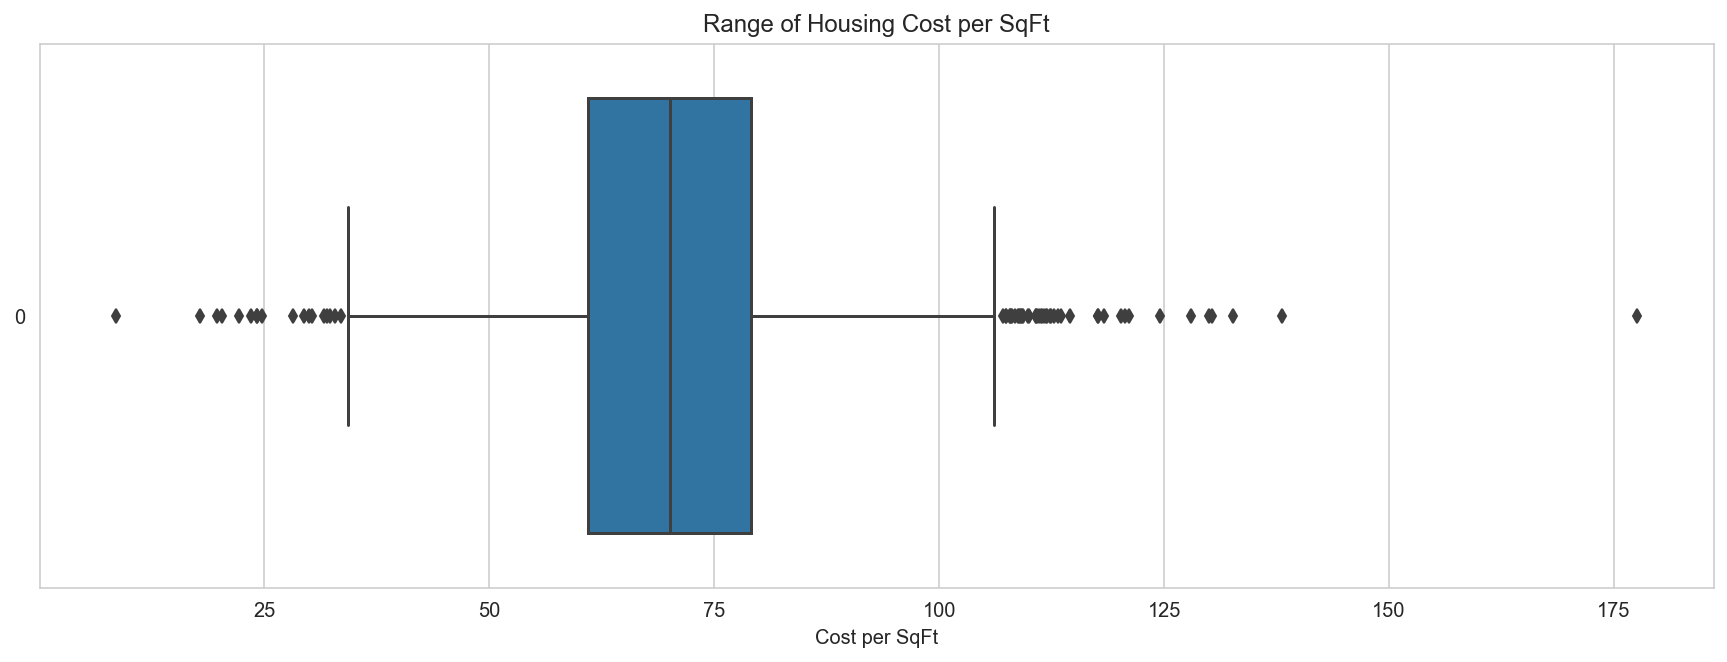

In [69]:
#boxplot of cost per sqft to identify outliers
plt.figure(figsize=(15,5))
sns.set_style('whitegrid')

sns.boxplot(data=cost_per_sqft,orient='h')
plt.title('Range of Housing Cost per SqFt')
plt.xlabel('Cost per SqFt');

# Observations: based on the boxplot, the median cost_per_sqft is $70 and the extreme outlier which has a cost per sqft in excess of 175 will be eliminiated

In [70]:
house.drop(index= 1210, inplace=True)

In [71]:
# check if number of rows has decreased by 1 
house.shape

(2048, 120)

#### <u>No Remod</u>

To have a comparison of the houses that were remod. The distribution looks fairly balanced for the train set.

In [72]:
# check the number of houses that were remod
house['no_remod'] = (house['YearBuilt']== house['YearRemod/Add'])
house['no_remod'] = house['no_remod'].map(lambda x: 1 if x == True else 0)
print(house['no_remod'].value_counts())

# distribution looks fairly balanced with slightly less than half of houses having undergone remod

#on test set
test['no_remod'] = (test['YearBuilt']== test['YearRemod/Add'])
test['no_remod'] = test['no_remod'].map(lambda x: 1 if x == True else 0)

1    1099
0     949
Name: no_remod, dtype: int64


#### <u>Years Before Sale</u>

Check the number of years between YearBuilt and YrSold, which gives a sense of age of house. YearSold, YearBuilt and Year Remod/Add will be dropped as I will use the new features.

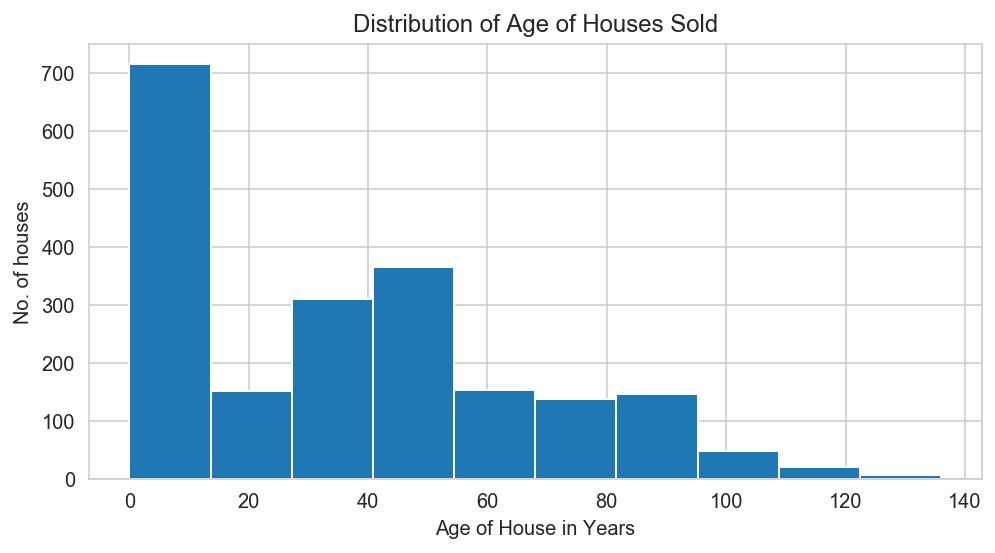

In [73]:
# check the number of years between YearBuilt and YrSold, which gives a sense of age of house 
house['yrs_bef_sale'] = (house['YrSold'] - house['YearBuilt'])
house['yrs_bef_sale'].value_counts()

# histogram of Age of Houses Sold
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(house['yrs_bef_sale'], bins=10)
ax.set_title('Distribution of Age of Houses Sold')
ax.set_xlabel('Age of House in Years')
ax.set_ylabel('No. of houses')
ax.grid(b=True)

# wide distribution of the age of houses that were sold, most of them fall betwen 1 to 10 years old 

#on test set
test['yrs_bef_sale'] = (test['YrSold'] - test['YearBuilt'])
# test['yrs_bef_sale'].value_counts()


In [74]:
#Drop YearBuilt, YearRemod/Add and YrSold
house.drop(columns = ['YearBuilt','YearRemod/Add','YrSold'], inplace=True)
test.drop(columns = ['YearBuilt','YearRemod/Add','YrSold'], inplace=True)

# check
print(house.shape)
test.shape

(2048, 119)


(879, 118)

#### <u>Total Porch SF</u>

Total porch SF will be created from Open Porch SF, Enclosed Porch, 3SsnPorch and Screen Porch to reduce the number of features. The original features will be dropped.

In [75]:
#create total porch as a new feature
house['total_porchSF'] = (house['OpenPorchSF'] + house['EnclosedPorch'] + house['3SsnPorch'] +house['ScreenPorch'])
print(house['total_porchSF'].head())

#on test set
test['total_porchSF'] = (test['OpenPorchSF'] + test['EnclosedPorch'] + test['3SsnPorch'] +test['ScreenPorch'])
test['total_porchSF'].head()

0    44
1    74
2    52
3     0
4    59
Name: total_porchSF, dtype: int64


0    172
1      0
2     24
3    184
4    261
Name: total_porchSF, dtype: int64

In [76]:
#Drop OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch
house.drop(columns = ['OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'], inplace=True)
test.drop(columns = ['OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'], inplace=True)

# check
print(house.shape)
test.shape

(2048, 116)


(879, 115)

#### <u>Total Bath </u>

Total bath will be created from Full Bath, Half Bath, Bsmt Full Bath, Bsmt Half Bath to reduce the number of features. The original features will be dropped.

In [77]:
#create total bath as a new feature
house['total_bath'] = (house['FullBath'] + house['HalfBath'] + house['BsmtFullBath'] +house['BsmtHalfBath'])
print(house['total_bath'].value_counts())

#on test set
test['total_bath'] = (test['FullBath'] + test['HalfBath'] + test['BsmtFullBath'] +test['BsmtHalfBath'])
# test['total_bath'].value_counts()

2.0    815
3.0    657
1.0    315
4.0    242
5.0     13
6.0      4
8.0      2
Name: total_bath, dtype: int64


In [78]:
#Drop FullBath,HalfBath,BsmtFullBath,BsmtHalfBath
house.drop(columns = ['FullBath','HalfBath','BsmtFullBath','BsmtHalfBath'], inplace=True)
test.drop(columns = ['FullBath','HalfBath','BsmtFullBath','BsmtHalfBath'], inplace=True)

# check
print(house.shape)
test.shape

(2048, 113)


(879, 112)

In [79]:
#save cleaned data to csv
house.to_csv('../datasets/train_clean.csv')
test.to_csv('../datasets/test_clean.csv')

<a id='Modeling'></a>

## Modeling

We will attempt to run 1 round of Modeling using Linear Regression, Lasso and Ridge. Thereafter, Lasso will also be used for further feature selection and fine-tuning. Train-test-split will be applied on train set for model validation and selection.

<p>The following metrics will be used to validate the model:</p>
<ol>
<li>Root Mean Square Error: this metric is used for evaluation on Kaggle </li>
<li>R^2 Score of Model</li>
<li>Adjusted R^2 of Model to account for the number of parameters </li>

</ol>


In [80]:
#function that returns Adjusted R2 score
def r2_adj(y_true, y_pred, p):
    n = len(y_true)
    y_mean = np.mean(y_true)
    numerator = np.sum(np.square(y_true - y_pred)) / (n - p - 1)
    denominator = np.sum(np.square(y_true - y_mean)) / (n - 1)
    return 1 - numerator / denominator

In [81]:
#function that returns metrics of model-> root mean squared error, r2 and adjusted r2
def metrics(y_true,y_pred,p):
    
    rmse = (np.sqrt(mean_squared_error(y_true,y_pred)))
    r2 = r2_score(y_true,y_pred)
    r2a = r2_adj(y_true, y_pred, p)
    
    print(f'Root Mean Squared Error= {rmse}')
    print(f'R2 Score = {r2}')
    print(f'Adjusted R2 Score = {r2a}')
    
    return 

#### Round 1 of Model Fitting: Training Model with All Features
As the first cut, we will use all the features obtained post-EDA and Feature Engineering to train the model.

In [82]:
# Selecting Features Using Lasso Regularisation 
# Separating house data set into train and test sets for model selection

features = [x for x in house.columns if x != 'SalePrice']
X = house[features]
y = house['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=7)

In [83]:
# X.head()

In [84]:
X_train.shape, X_test.shape

((1536, 112), (512, 112))

In [85]:
#Scaling the data
ss = StandardScaler()

ss.fit(X_train)
X_train_scale = ss.transform(X_train)
X_test_scale = ss.transform(X_test)

###### Model 1: Linear Regression 

Findings: 

The adjusted R^2 is extremely negative. The linear regression is performing far worse than baseline on the test sets. It is probably dramatically overfitting and the redundant variables are affecting the coefficients.

In [86]:
# Model 1: Linear Regression 

lr = LinearRegression()
lr.fit(X_train_scale,y_train)

y_pred_lr = lr.predict(X_test_scale)

# lr_scores = cross_val_score(lr, X_train_scale, y_train, cv=10)

In [87]:
#score the Linear Regression Model
print('Metrics for Model 1: Linear Regression')
print('=======================================')
metrics(y_test,y_pred_lr,X.shape[1])


Metrics for Model 1: Linear Regression
Root Mean Squared Error= 452426949011163.94
R2 Score = -3.0068802144633844e+19
Adjusted R2 Score = -3.850916765891703e+19


###### Model 2: Lasso

Findings: 

The adjusted R^2 compared to the linear regression has improved significantly. This is expected as lasso reduces the coefficients of some variables to zero. Lasso is also used for feature selection, hence I will take a look at the lasso coefficients to fine tune the features for the subsequent model.

In [88]:
# Model 2 : Lasso 
# find optimal regression alpha for Lasso

optimal_lasso = LassoCV(n_alphas=500, cv=10)
optimal_lasso.fit(X_train_scale, y_train)

print(optimal_lasso.alpha_)

535.4681723192919


In [89]:
# Model 2 : Lasso 
# Creating Lasso Model and use for feature selection 

# lasso_scores = cross_val_score(lasso, X_train_scale, y_train, cv=10)

# print(lasso_scores)
# print(lasso_scores.mean())

In [90]:
# Model 2 : Lasso 
# get coeff from Lasso Model to find predictors that get dropped to zero
lasso = Lasso(alpha=optimal_lasso.alpha_)       #Lasso with optimal alpha

lasso.fit(X_train_scale, y_train)

lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(30)

,variable,coef,abs_coef
12,GrLivArea,22950.240144,22950.240144
3,OverallQual,10947.800043,10947.800043
10,TotalBsmtSF,9278.155377,9278.155377
44,Neighborhood_NridgHt,7398.211019,7398.211019
6,ExterQual,7354.954253,7354.954253
109,yrs_bef_sale,-7258.753679,7258.753679
50,Neighborhood_StoneBr,7044.759565,7044.759565
1,LotArea,6758.989488,6758.989488
5,MasVnrArea,5641.976325,5641.976325
19,GarageArea,5615.391548,5615.391548


In [91]:
#Lasso model has reduced the coefficients of 50 features to zero
lasso_coefs.tail(51)

,variable,coef,abs_coef
23,LotConfig_FR2,-14.94653,14.94653
103,GarageType_Basment,-0.00000,0.00000
92,Exterior2nd_Wd Shng,-0.00000,0.00000
21,PoolArea,0.00000,0.00000
86,Exterior2nd_MetalSd,0.00000,0.00000
87,Exterior2nd_Plywood,-0.00000,0.00000
88,Exterior2nd_Stone,-0.00000,0.00000
89,Exterior2nd_Stucco,-0.00000,0.00000
2,LotShape,0.00000,0.00000
91,Exterior2nd_Wd Sdng,0.00000,0.00000


In [92]:
# get predictions for lasso and use score to get the R2 value
y_pred_lasso = lasso.predict(X_test_scale)
lasso.score(X_test_scale,y_test)

#score the Lasso Model
print('Metrics for Model 2: Lasso')
print('=======================================')
metrics(y_test,y_pred_lasso,X.shape[1])

Metrics for Model 2: Lasso
Root Mean Squared Error= 26873.30958188059
R2 Score = 0.8939131617933802
Adjusted R2 Score = 0.8641344001915219


###### Model 3: Ridge

Findings: 

The adjusted R^2 compared to the linear regression has improved significantly. However, Lasso seems to be performing marginally better in terms of R^2 score.

In [93]:
# Model 3 : Ridge
# find optimal regression alpha for Ridge

ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train_scale, y_train)

print(optimal_ridge.alpha_)

91.15888299750823


In [94]:
# Model 3 : Ridge 
# Creating Ridge Model using optimal alpha
y_pred_ridge = optimal_ridge.predict(X_test_scale)

# ridge_scores = cross_val_score(ridge, X_train_scale, y_train, cv=10)

# print(ridge_scores)
# print(np.mean(ridge_scores))

#score the Ridge Model
print('Metrics for Model 3: Ridge')
print('=======================================')
metrics(y_test,y_pred_ridge,X.shape[1])

Metrics for Model 3: Ridge
Root Mean Squared Error= 26603.652529656694
R2 Score = 0.8960315117405908
Adjusted R2 Score = 0.8668473746853181


###### Round 1 of Model Fitting and Selection

Findings: 

Based on the adjusted R^2 scores,  the Ridge Model has a marginally better performance than Lasso and will be selected. 

In [95]:
# scale full train data fit on ridge model
X_train_full = ss.fit_transform(X)
X_test_full = ss.fit_transform(test)

In [96]:
# retrain lasso model on entire train data set
optimal_ridge.fit(X_train_full, y)

y_pred_5 = optimal_ridge.predict(X_test_full)

In [97]:
#save predicted sale price into csv for kaggle file 
 
y_pred_5  = pd.DataFrame(y_pred_5 )   #convert predictions to data frame
id_num = test_id                #get a copy of test ids 
kaggle_trial5 = pd.concat([id_num,y_pred_5], axis=1,sort=False)
    
kaggle_trial5.rename(columns={0:'SalePrice'}, inplace=True)

kaggle_trial5.to_csv('../datasets/kaggle_trial5.csv', index=False)

#### Round 1: Results
Kaggle Submission for above obtained a public score of 36061.03762

#### Round 2 of Model Fitting: : Training Model with Top 20 Features obtained from Lasso

I will now use the top 20 features obtained from Lasso to train the model.

<u>Reviewing Feature Selection</u>

- The next model will use the top 20 (in terms of absolute value) for model fitting. From the plot below it can be seen that GrLivArea has the greatest impact on SalePrice and it may be worth fitting a higher order polynomial. 
- Another interesting observation is that neighborhoods seem to play a significant role in SalePrice, with 3 out of 20 features being neighbourhood and it will be worth exploring this feature further. 
- In terms of negative relationships, yrs_bef_sale which is the age of the house before it was sold has a negative relationship. This makes sense as the older the house, it will penalise the SalePrice 



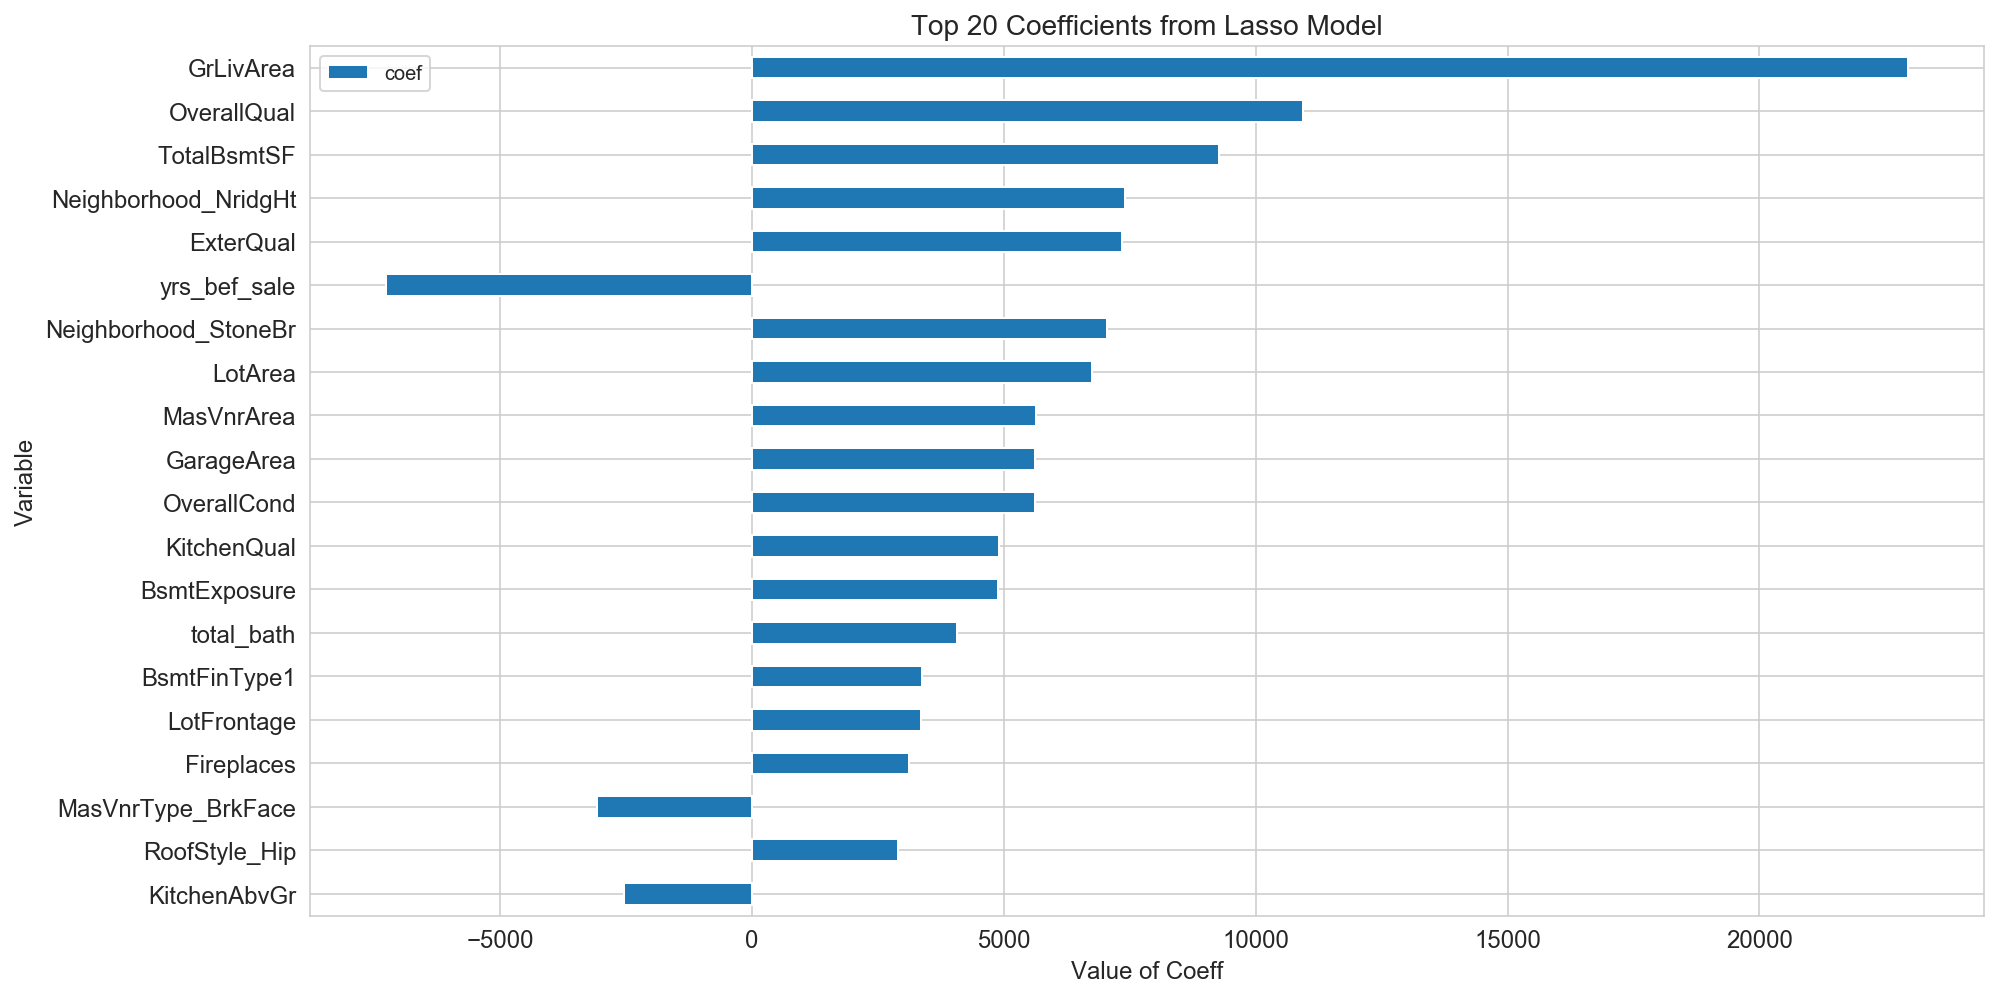

In [98]:
# Reviewing Feature Selection
# Plot coefficients from Lasso Model
top20 = lasso_coefs.head(20)[['variable','coef']]
top20 = top20.set_index('variable')

top20.plot(kind='barh',figsize=(15,8), fontsize=12)
plt.gca().invert_yaxis()
plt.title("Top 20 Coefficients from Lasso Model", fontsize=14)
plt.ylabel('Variable', fontsize=12)
plt.xlabel('Value of Coeff',fontsize=12);

plt.savefig('../figure/Top20LassoCoef')

In [99]:
top20_fea = lasso_coefs.head(20)['variable']
top20_fea

12                GrLivArea
3               OverallQual
10              TotalBsmtSF
44     Neighborhood_NridgHt
6                 ExterQual
109            yrs_bef_sale
50     Neighborhood_StoneBr
1                   LotArea
5                MasVnrArea
19               GarageArea
4               OverallCond
15              KitchenQual
8              BsmtExposure
111              total_bath
9              BsmtFinType1
0               LotFrontage
16               Fireplaces
93       MasVnrType_BrkFace
62            RoofStyle_Hip
14             KitchenAbvGr
Name: variable, dtype: object

In [100]:
# Separating house data set into train and test sets for model selection

X2 = house[top20_fea]
y2 = house['SalePrice']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2,random_state=7)

In [101]:
X2_train.shape, X2_test.shape

((1536, 20), (512, 20))

In [102]:
#Scaling the data
ss = StandardScaler()

ss.fit(X2_train)
X2_train_scale = ss.transform(X2_train)
X2_test_scale = ss.transform(X2_test)

###### Model 1: Linear Regression 

Findings: 

The adjusted R^2 is no longer negative and the linear regression is performing better than baseline. The reduction to 20 features to fit the model has reduced the effect of overfitting.

In [103]:
# Model 1: Linear Regression 

lr = LinearRegression()
lr.fit(X2_train_scale,y2_train)

y_pred_lr2 = lr.predict(X2_test_scale)

#score the Linear Regression Model
print('Metrics for Model 1: Linear Regression')
print('=======================================')
metrics(y2_test,y_pred_lr2,X2.shape[1])


Metrics for Model 1: Linear Regression
Root Mean Squared Error= 28928.29912873982
R2 Score = 0.8770679866042682
Adjusted R2 Score = 0.872060572616662


###### Model 2: Lasso

Findings: 

The adjusted R^2 is comparable to the score for linear regression and is only marginally better than the previous model with 100 over features.

In [104]:
# Model 2 : Lasso 
# find optimal regression alpha for Lasso

optimal_lasso = LassoCV(n_alphas=500, cv=10)
optimal_lasso.fit(X2_train_scale, y2_train)

print(optimal_lasso.alpha_)

y2_pred_lasso = optimal_lasso.predict(X2_test_scale)

#score the Lasso Model
print('Metrics for Model 2: Lasso')
print('=======================================')
metrics(y2_test,y2_pred_lasso,X2.shape[1])


63.51582720019907
Metrics for Model 2: Lasso
Root Mean Squared Error= 28912.015674138594
R2 Score = 0.8772063420924614
Adjusted R2 Score = 0.8722045637662887


###### Model 3: Ridge

Findings: 

The adjusted R^2 is comparable to the score for linear regression and is only marginally better than the previous model with 100 over features

In [105]:
# Model 3 : Ridge
# find optimal regression alpha for Ridge

ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X2_train_scale, y2_train)

print(optimal_ridge.alpha_)

y_pred_ridge2 = optimal_ridge.predict(X2_test_scale)

#score the Ridge Model
print('Metrics for Model 3: Ridge')
print('=======================================')
metrics(y2_test,y_pred_ridge2,X2.shape[1])

# The R^2 is comparable to the score for linear regression and is only marginally better than the previous model with 100 over features

27.049597304631355
Metrics for Model 3: Ridge
Root Mean Squared Error= 28923.51613755323
R2 Score = 0.8771086342846321
Adjusted R2 Score = 0.8721028760070205


#### Round 3 of Model Fitting: : Review Feature Selection from Top 20 to 30 Features (from Lasso)

Seems like the r^2 scores did not improve drastically when the top 20 features were selected. I will now review the feature selection from the top 20 to 30 features obtained from Lasso.

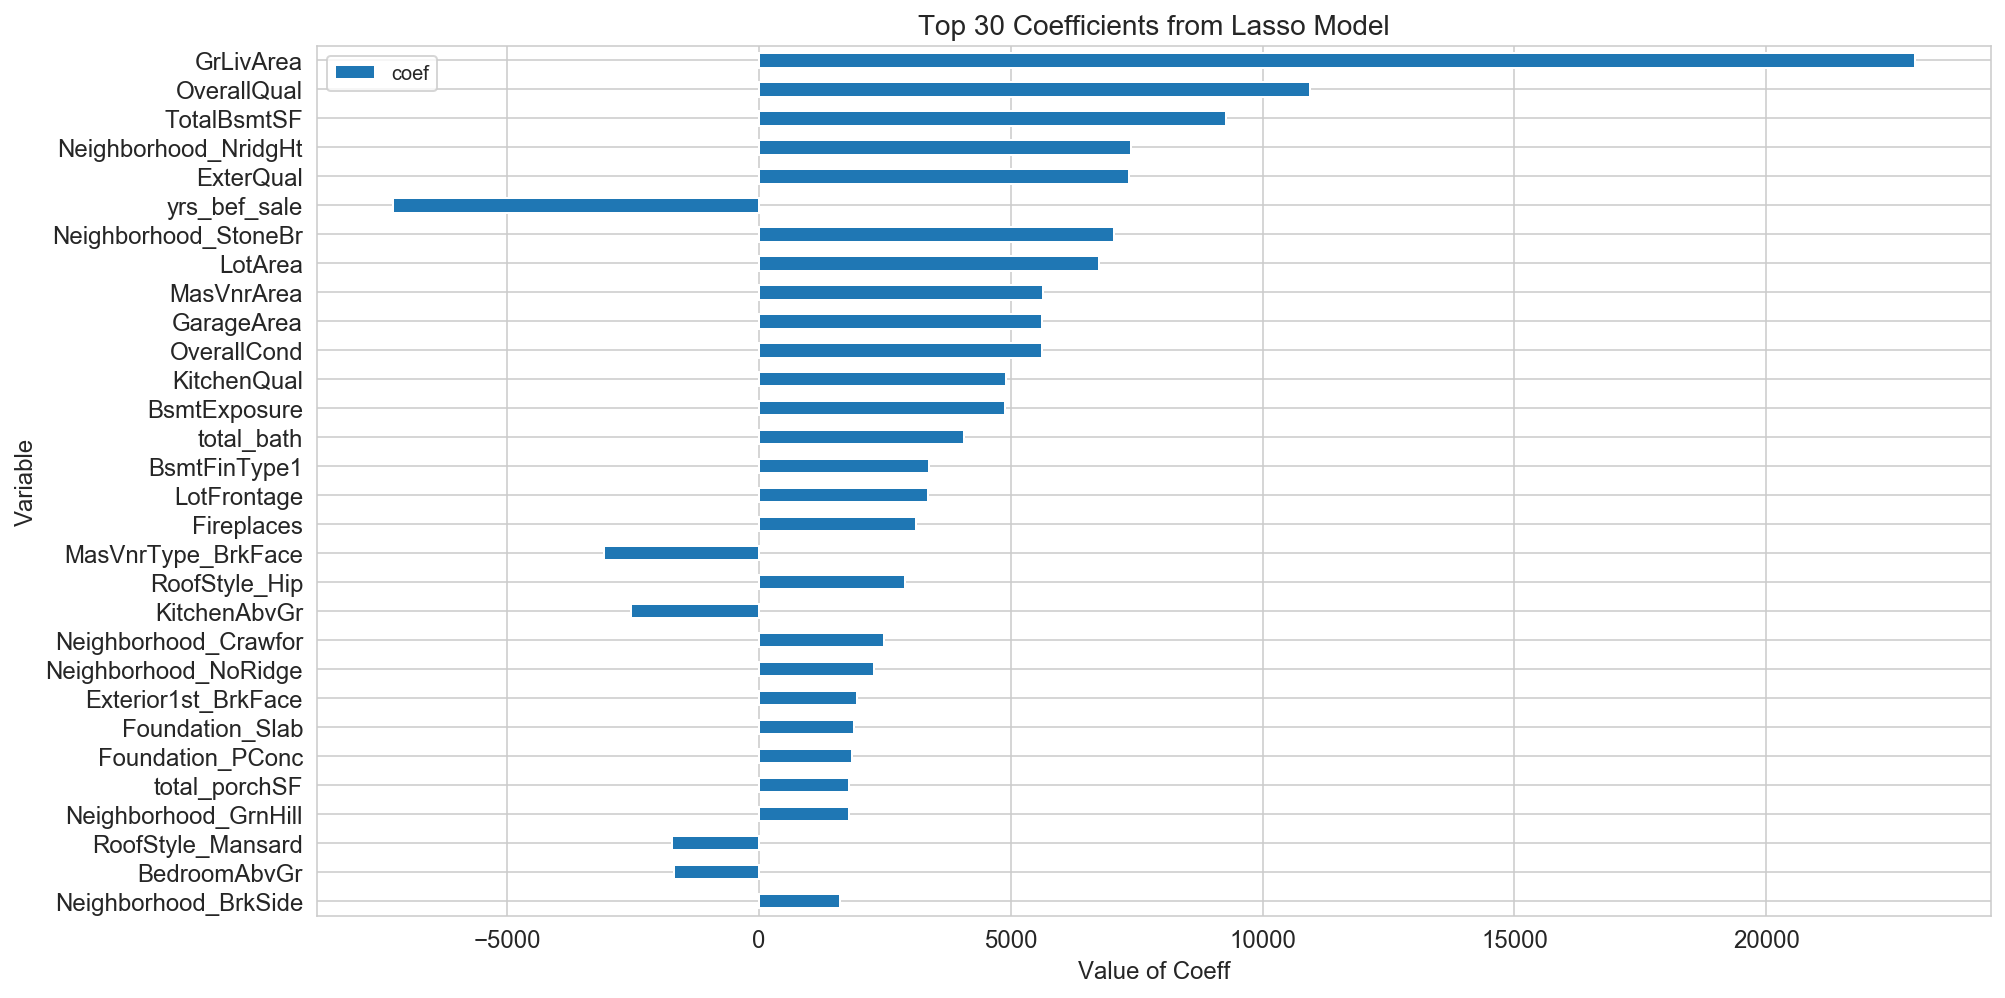

In [106]:

# We shall take a look at the top 30 coefficients from Lasso Model
top30 = lasso_coefs.head(30)[['variable','coef']]
top30 = top30.set_index('variable')

top30.plot(kind='barh',figsize=(15,8), fontsize=12)
plt.gca().invert_yaxis()
plt.title("Top 30 Coefficients from Lasso Model", fontsize=14)
plt.ylabel('Variable', fontsize=12)
plt.xlabel('Value of Coeff',fontsize=12);


In [107]:
top30_fea = lasso_coefs.head(30)['variable']
top30_fea

12                GrLivArea
3               OverallQual
10              TotalBsmtSF
44     Neighborhood_NridgHt
6                 ExterQual
109            yrs_bef_sale
50     Neighborhood_StoneBr
1                   LotArea
5                MasVnrArea
19               GarageArea
4               OverallCond
15              KitchenQual
8              BsmtExposure
111              total_bath
9              BsmtFinType1
0               LotFrontage
16               Fireplaces
93       MasVnrType_BrkFace
62            RoofStyle_Hip
14             KitchenAbvGr
31     Neighborhood_Crawfor
43     Neighborhood_NoRidge
67      Exterior1st_BrkFace
99          Foundation_Slab
98         Foundation_PConc
110           total_porchSF
35     Neighborhood_GrnHill
63        RoofStyle_Mansard
13             BedroomAbvGr
28     Neighborhood_BrkSide
Name: variable, dtype: object

In [108]:
# Separating house data set into train and test sets for model selection

X3 = house[top30_fea]
y3 = house['SalePrice']

X3_train, X3_test, y3_train, y3_test = train_test_split(X3,y3,random_state=7)

In [109]:
#Scaling the data
ss = StandardScaler()

ss.fit(X3_train)
X3_train_scale = ss.transform(X3_train)
X3_test_scale = ss.transform(X3_test)

###### Model 1: Linear Regression 

Findings: 

The addition of 10 features to improved the model as compared to only fitting the top 20 features. The R^2 score has improved by approx 0.03. The improvement is still marginal.

In [110]:
# Model 1: Linear Regression 

lr = LinearRegression()
lr.fit(X3_train_scale,y3_train)

y_pred_lr3 = lr.predict(X3_test_scale)

#score the Linear Regression Model
print('Metrics for Model 1: Linear Regression')
print('=======================================')
metrics(y3_test,y_pred_lr3,X3.shape[1])

# The R^2 is still negative but better than the earlier regression with 100 over variables. 
# The linear regression is still performing worse than baseline on the test sets.

Metrics for Model 1: Linear Regression
Root Mean Squared Error= 27155.16906260711
R2 Score = 0.8916761175081163
Adjusted R2 Score = 0.8849199502009302


###### Model 2: Lasso

Findings: 

The adjusted R^2 has also improved compared to the previous model with 20 features. The adjusted R^2 score is also comparable to the score obtained for Linear Regression.

In [111]:
# Model 2 : Lasso 
# find optimal regression alpha for Lasso

optimal_lasso = LassoCV(n_alphas=500, cv=10)
optimal_lasso.fit(X3_train_scale, y3_train)

print(optimal_lasso.alpha_)

y_pred_lasso3 = optimal_lasso.predict(X3_test_scale)

#score the Lasso Model
print('Metrics for Model 2: Lasso')
print('=======================================')
metrics(y3_test,y_pred_lasso3,X3.shape[1])

62.64262300810829
Metrics for Model 2: Lasso
Root Mean Squared Error= 27152.079911703822
R2 Score = 0.8917007617874517
Adjusted R2 Score = 0.8849461315455048


###### Model 3: Ridge

Findings: 

Similar to Lasso, the adjusted R^2 has also improved compared to the previous model with 20 features. The adjusted R^2 score is also comparable to the score obtained for Linear Regression.

In [112]:
# Model 3 : Ridge
# find optimal regression alpha for Ridge

ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X3_train_scale, y3_train)

print(optimal_ridge.alpha_)

y_pred_ridge3 = optimal_ridge.predict(X3_test_scale)

#score the Ridge Model
print('Metrics for Model 3: Ridge')
print('=======================================')
metrics(y3_test,y_pred_ridge3,X3.shape[1])

38.27494478516313
Metrics for Model 3: Ridge
Root Mean Squared Error= 27169.127091961862
R2 Score = 0.891564729763364
Adjusted R2 Score = 0.8848016151955904


In [113]:
# test set with top 30 features
test3 = test[top30_fea]

# scale full train data fit on ridge model
X_train_full3 = ss.fit_transform(X3)
X_test_full3 = ss.fit_transform(test3)

In [114]:
#retrain current lasso model on entire train data set
optimal_ridge.fit(X_train_full3,y)

y_pred_6= optimal_lasso.predict(X_test_full3)

In [115]:
#save predicted sale price into csv for kaggle file 
 
y_pred_6  = pd.DataFrame(y_pred_6 )   #convert predictions to data frame
id_num = test_id                #get a copy of test ids 
kaggle_trial6 = pd.concat([id_num,y_pred_6], axis=1,sort=False)
    
kaggle_trial6.rename(columns={0:'SalePrice'}, inplace=True)

kaggle_trial6.to_csv('../datasets/kaggle_trial6.csv', index=False)

#### Round 4 of Model Fitting: Reviewing Feature Selection of top 20 features by considering polynomial features for top 5 variables

Seems like the r^2 scores did not improve drastically when the top 20 features were selected. There was slight improvement when 30 features were considered. During the EDA, the relationship between SalePrice and GrLivArea may be of higher order. A similar observation can be made for TotalBsmtSFwhich is among the top 5 features based on the Lasso coefficients. I will now take a look at effect when the top 5 features GrLivArea, OverallQual,TotalBsmtSF,Neighborhood_NridgHt and ExterQual are squared. 

In [116]:
# Squaring the top 5 features GrLivArea, OverallQual,TotalBsmtSF,Neighborhood_NridgHt and ExterQual

house['GrLivArea_Sq'] = house['GrLivArea']**2
house['OverallQual_Sq'] = house['OverallQual']**2
house['TotalBsmtSF_Sq'] = house['TotalBsmtSF']**2
house['Neighborhood_NridgHt_Sq'] = house['Neighborhood_NridgHt']**2
house['ExterQual'] = house['ExterQual']**2

sq_fea = ['GrLivArea_Sq','OverallQual_Sq','TotalBsmtSF_Sq','Neighborhood_NridgHt','ExterQual']
top15 = top20_fea[5:]

new20_fea = list(sq_fea)+  list(top15)
new20_fea
display(house.head())

# repeat for test set

test['GrLivArea_Sq'] = test['GrLivArea']**2
test['OverallQual_Sq'] = test['OverallQual']**2
test['TotalBsmtSF_Sq'] = test['TotalBsmtSF']**2
test['Neighborhood_NridgHt_Sq'] = test['Neighborhood_NridgHt']**2
test['ExterQual'] = test['ExterQual']**2

test.head()

,LotFrontage,LotArea,LotShape,OverallQual,OverallCond,MasVnrArea,ExterQual,BsmtQual,BsmtExposure,BsmtFinType1,TotalBsmtSF,HeatingQC,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,Fireplaces,FireplaceQu,GarageFinish,GarageArea,WoodDeckSF,PoolArea,SalePrice,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_No,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No,no_remod,yrs_bef_sale,total_porchSF,total_bath,GrLivArea_Sq,OverallQual_Sq,TotalBsmtSF_Sq,Neighborhood_NridgHt_Sq
0,0.0,13517,2,6,8,289.0,4,3,1,6,725.0,4,1479,3,1,2,0,0,2,475.0,0,0,130500,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,34,44,3.0,2187441,36,525625.0,0
1,43.0,11492,2,7,5,132.0,4,4,1,6,913.0,4,2122,4,1,2,1,3,2,559.0,0,0,220000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,13,74,4.0,4502884,49,833569.0,0
2,68.0,7922,3,5,7,0.0,1,3,1,6,1057.0,2,1057,3,1,2,0,0,1,246.0,0,0,109000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,57,52,2.0,1117249,25,1117249.0,0
3,73.0,9802,3,5,5,0.0,1,4,1,1,384.0,3,1444,3,1,1,0,0,3,400.0,100,0,174000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,4,0,3.0,2085136,25,147456.0,0
4,82.0,14235,2,6,8,0.0,1,2,1,1,676.0,2,1445,3,1,1,0,0,1,484.0,0,0,138500,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,110,59,2.0,2088025,36,456976.0,0


,LotFrontage,LotArea,LotShape,OverallQual,OverallCond,MasVnrArea,ExterQual,BsmtQual,BsmtExposure,BsmtFinType1,TotalBsmtSF,HeatingQC,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,Fireplaces,FireplaceQu,GarageFinish,GarageArea,WoodDeckSF,PoolArea,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_No,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No,Neighborhood_GrnHill,Neighborhood_Landmrk,Exterior1st_CBlock,Exterior1st_ImStucc,Exterior1st_Stone,Exterior2nd_Stone,no_remod,yrs_bef_sale,total_porchSF,total_bath,GrLivArea_Sq,OverallQual_Sq,TotalBsmtSF_Sq,Neighborhood_NridgHt_Sq
0,69.0,9142,3,6,8,0.0,1,2,1,1,1020,2,1928,4,2,1,0,0,1,440,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,96,172,2,3717184,36,1040400,0
1,0.0,9662,2,5,4,0.0,1,4,1,1,1967,1,1967,6,2,2,0,0,3,580,170,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,29,0,2,3869089,25,3869089,0
2,58.0,17104,2,7,5,0.0,4,4,3,6,654,3,1496,3,1,3,1,4,2,426,100,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,24,4,2238016,49,427716,0
3,60.0,8520,3,5,6,0.0,4,3,1,1,968,1,968,2,1,2,0,0,1,480,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,84,184,1,937024,25,937024,0
4,0.0,9500,2,6,5,247.0,1,4,1,4,1394,2,1394,3,1,2,2,4,2,514,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,46,261,3,1943236,36,1943236,0


In [117]:
# Model-tuning with features from Lasso Regularisation 
# Separating house data set into train and test sets for model selection

X4 = house[new20_fea]
y4 = house['SalePrice']

X4_train, X4_test, y4_train, y4_test = train_test_split(X4,y4,random_state=7)

In [118]:
#Scaling the data
ss = StandardScaler()

ss.fit(X4_train)
X4_train_scale = ss.transform(X4_train)
X4_test_scale = ss.transform(X4_test)

###### Model 1: Linear Regression 

Findings: 

The squaring of top 5 features also improved the model compared to the second round when we used the top 20 features. The R^2 score has improved by approx 0.02. There may be some sort of polynomial relationship between the top 5 features that were covered earlier. 

In [119]:
# Model 1: Linear Regression 

lr = LinearRegression()
lr.fit(X4_train_scale,y4_train)

y_pred_lr4 = lr.predict(X4_test_scale)

#score the Linear Regression Model
print('Metrics for Model 1: Linear Regression')
print('=======================================')
metrics(y4_test,y_pred_lr4,X4.shape[1])

# The R^2 is still negative but better than the earlier regression with 100 over variables. 
# The linear regression is still performing worse than baseline on the test sets.

Metrics for Model 1: Linear Regression
Root Mean Squared Error= 25714.358005197944
R2 Score = 0.9028661578900681
Adjusted R2 Score = 0.8989095859100302


###### Model 2: Lasso

Findings: 

The adjusted R^2 is comparable to the score for linear regression and the model seems to perform better than the model from the second round where polynomial features were not considered.

In [120]:
# Model 2 : Lasso 
# find optimal regression alpha for Lasso

optimal_lasso = LassoCV(n_alphas=500, cv=10)
optimal_lasso.fit(X4_train_scale, y4_train)

print(optimal_lasso.alpha_)

y_pred_lasso4 = optimal_lasso.predict(X4_test_scale)

#score the Lasso Model
print('Metrics for Model 2: Lasso')
print('=======================================')
metrics(y4_test,y_pred_lasso4,X4.shape[1])

64.56098470027673
Metrics for Model 2: Lasso
Root Mean Squared Error= 25696.94308169787
R2 Score = 0.9029976801798839
Adjusted R2 Score = 0.8990464655232601


###### Model 3: Ridge

Findings: 

Similar to Lasso, the adjusted R^2 has also improved compared to the previous model with 20 features. The performance of Lasso seems to be better than Ridge. 

In [121]:
# Model 3 : Ridge
# find optimal regression alpha for Ridge

ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X4_train_scale, y4_train)

print(optimal_ridge.alpha_)

y_pred_ridge4 = optimal_ridge.predict(X4_test_scale)

#score the Ridge Model
print('Metrics for Model 3: Ridge')
print('=======================================')
metrics(y4_test,y_pred_ridge4,X4.shape[1])

34.09285069746813
Metrics for Model 3: Ridge
Root Mean Squared Error= 25741.80745321558
R2 Score = 0.9026586712059057
Adjusted R2 Score = 0.8986936476297716


###### Round 4 of Model Fitting and Selection

Findings: 

Based on the adjusted R^2 scores,  the Lasso Model is marginally better than the Ridge and Linear Regression models. Lasso will be selected. 

In [122]:
# scale full train data fit on lasso model
X4 = house[new20_fea]
test4 = test[new20_fea]

X_train_full4 = ss.fit_transform(X4)
X_test_full4 = ss.fit_transform(test4)

In [123]:
#retrain current lasso model on entire train data set
optimal_lasso.fit(X_train_full4,y)

y_pred_lasso_4 = optimal_lasso.predict(X_test_full4)

In [124]:
#save predicted sale price into csv for kaggle file 
y_pred_lasso_4 = pd.DataFrame(y_pred_lasso_4)
id_num = test_id
kaggle_trial4 = pd.concat([id_num,y_pred_lasso_4], axis=1,sort=False)

#rename sale price column
kaggle_trial4.rename(columns={0:'SalePrice'}, inplace=True)

#save to csv
kaggle_trial4.to_csv('../datasets/kaggle_trial4.csv', index=False)

#### Round 4: Kaggle Results
Kaggle Submission for above obtained a public score of 26638

<a id='Analysis-of-Model'></a>

## Analysis of Model 

#### Model Selected : Lasso Model with Top 20 Features (where top 5 were squared)

Findings: 

The squaring of top 5 features improved the R^2 of the model compared to the earlier rounds. This indicates there may be some sort of polynomial relationship between the top 5 features namely Gr Liv Area, Overall Qual, Total Bsmt SF, Neighborhood_NridgHt and Exter Qual.

Interpreting the coefficients of the 20 features selected:

- A unit increase in the feature will result in an increase/decrease  by the magnitude of the coefficients
- The + sign indicates an increase whereas the - sign indicates a decrease which suggests a negative relationship . For example, a unit increase in yrs_bef_sale will decrease sale price by \$7258
- In the case of the top 5 features, a unit increase in the square of the feature will increase the sale price by the magnitude of the coefficient. For example, a unit increase in GrLivArea**2 will increase sale price by \$22950

Discussion on the Top 10 Features: 

- Gr Liv Area has the highest weightage from the Lasso model, this makes sense as housing prices are typically a factor of the floor area (i.e. cost per square foot). The weight of this feature is close to double the weight of the second highest (Overall Qual) and it can be concluded that the house area is the major feature that impacts sale price. 
- Overall Qual has the second highest value. During the earlier EDA, it was established that Overall Qual seems to have a significant impact on sale price with higher quality houses having a significantly higher price as seen by the exponential increase in median sale price with increase in overall quality score. The findings from the Lasso coefficients also supports this. 
- Total Bsmt SF is also amongst the top 5 features with the highest Lasso coefficients, in this case the sum of Gr Liv Area and Total Bsmt SF make ups majority of the floor area of most of the houses and it 
- Exter Qual has a Lasso coefficient of 7394, this means that the external quality finish on the house also has significant weightage the sale price.

- Neighborhoods NridgeHt and StoneBr are the neighbourhoods with a significantly higher median price compared to the other estates. In this case, it would mean that a house in NridgeHt would have a \$7398 increase in sale price while a house in StoneBr would have a \\$7044 increase in price 
- Years Before Sale was Year Built subtracted from Year Sold, which gives an indication of the age of the house. This relationship is negative as a unit increase in year before sale would reduce sale price by \$7258
- The remaining 3 features with the highest weights are Lot Area, Mas Vnr Area and Garage Area. The lot area refers to the total land area of the property, where sale price increases with presence of lot area. Masonry veneer area refers to the cladded/facade on the structural wall, which again incurs more cost when a feature is present. Lastly, the presence of a garage area would increase the sale price for similar reasons

Other observations:

- KitchenAbvGr seems to give a negative penalty on sale price for a unit increase which defies our expectation where more rooms/area gives rise to a higher price. In the earlier EDA, it was observed that the range of houses with 1 kitchen had a wider spread of sale prices and there were a lot more observations of houses with 1 kitchen. One way to improve the model predictions would be to drop this feature as there may be insufficient observations to allow the model to discern the impact on sale price. 


In [125]:
lasso_coefs.head(20)

,variable,coef,abs_coef
12,GrLivArea,22950.240144,22950.240144
3,OverallQual,10947.800043,10947.800043
10,TotalBsmtSF,9278.155377,9278.155377
44,Neighborhood_NridgHt,7398.211019,7398.211019
6,ExterQual,7354.954253,7354.954253
109,yrs_bef_sale,-7258.753679,7258.753679
50,Neighborhood_StoneBr,7044.759565,7044.759565
1,LotArea,6758.989488,6758.989488
5,MasVnrArea,5641.976325,5641.976325
19,GarageArea,5615.391548,5615.391548


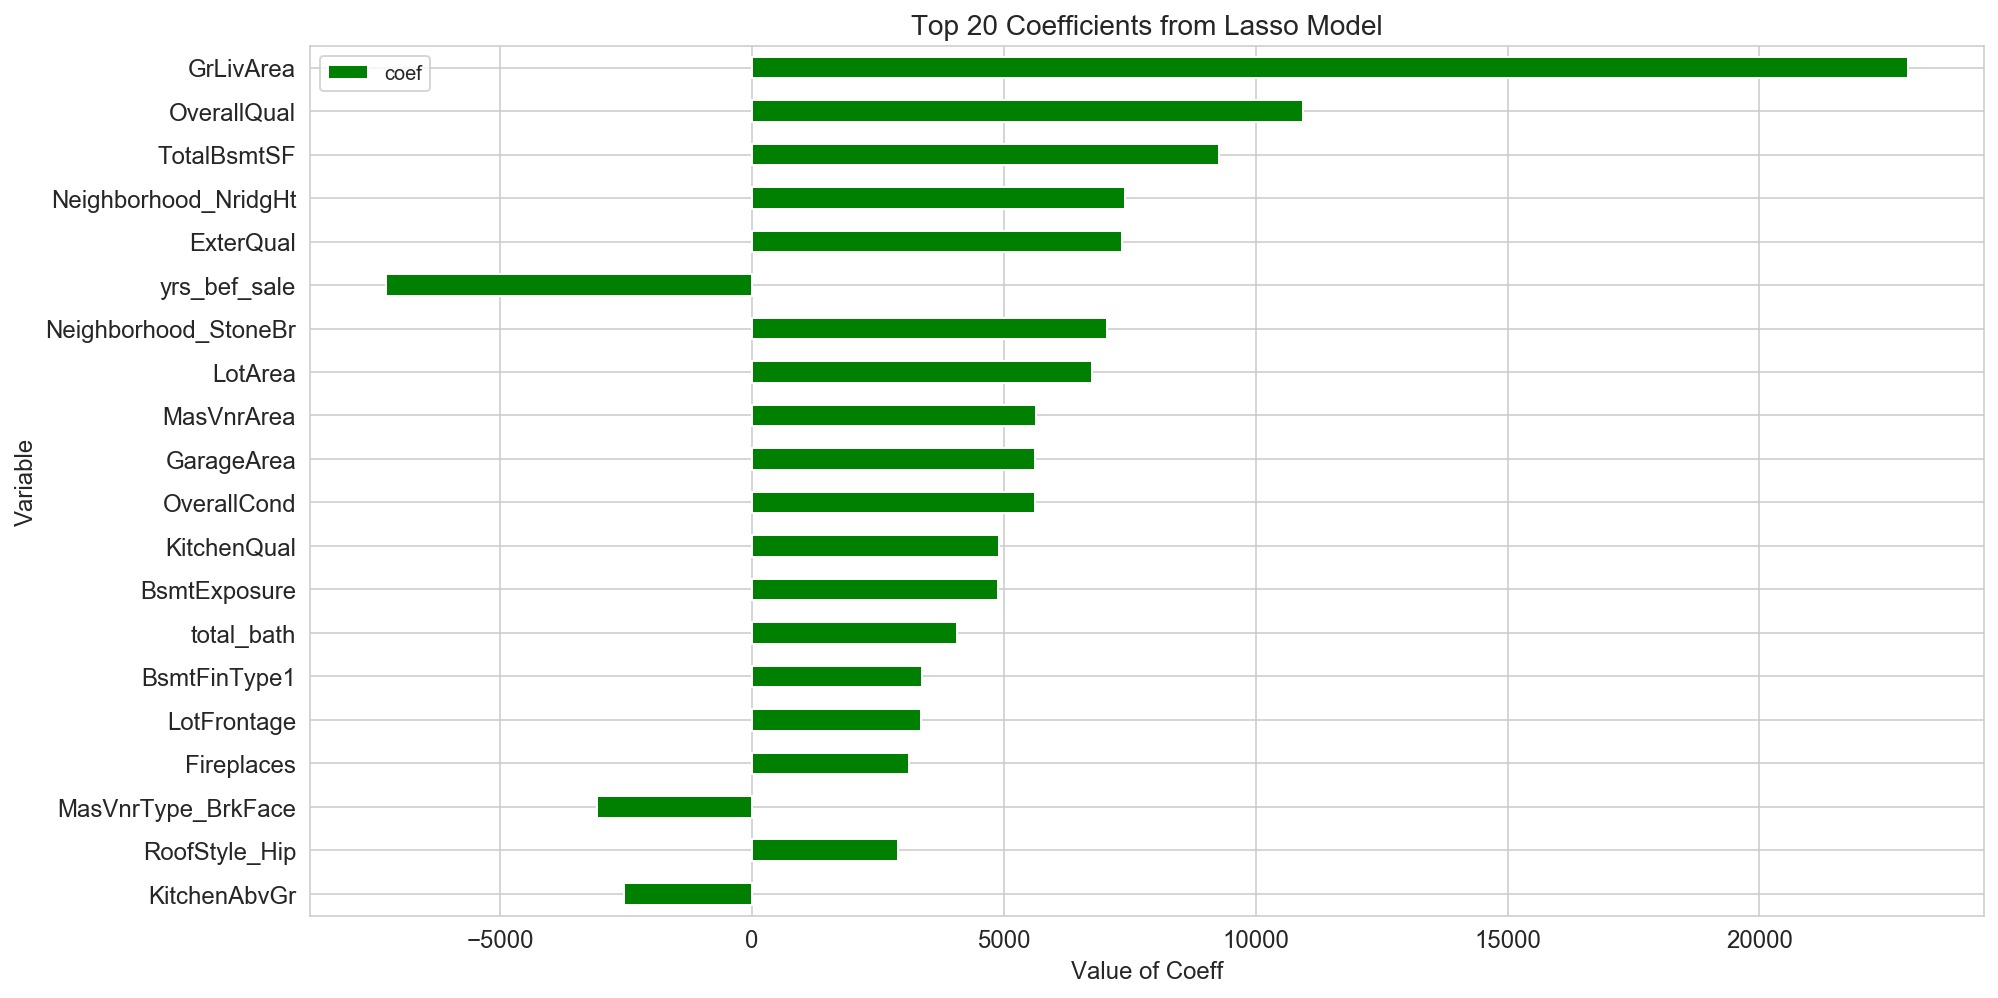

In [126]:
# Plot coefficients from final lasso model
final_features = lasso_coefs.head(20)[['variable','coef']]
final_features = final_features.set_index('variable')

final_features.plot(kind='barh',figsize=(15,8), fontsize=12,color='g')
plt.gca().invert_yaxis()
plt.title("Top 20 Coefficients from Lasso Model", fontsize=14)
plt.ylabel('Variable', fontsize=12)
plt.xlabel('Value of Coeff',fontsize=12);

plt.savefig('../figure/Final20LassoCoef')

<a id='Conclusion-and-Recommendations'></a>

## Conclusion & Recommendations 

Conclusion: 

- I have learnt that cleaning and feature selection is a very important process in order to get a model that is better at predicting the housing prices
- The use of Lasso also proved to come in handy as it was able to eliminate 50 out of 112 features.
- On prediction of housing prices, GrLivArea stood out as the feature with the greatest weightage on sale price. Followed by overall qual, total bsmt sqft, Neighborhood_NridgHt and Exter Qual. 
- The use of Lasso and Ridge performed better at the onset when there were too many features (100 over) which resulted in the Linear Regression Model overfitting 
- As seen from the improvement in R^2 scores when the top 5 features were squared, it may be worth exploring polynomial features for other specific features to see if it improves the model

Recommendations: 

- Neighborhood seems to have a significant effect on sale price, this feature can be studied in further detail - either by associating the neighborhoods by distance to city center and assigning weights
- Further tuning of the features would be a way to reduce the Root Mean Squared Error of the model and improve predictions. One feature that I would exclude would be the KitchenAbvGr due to the negative coefficient from the Lasso model. This is likely due to the fact that almost all of the houses have 1 kitchen and this may not be useful for the model to discern how this feature affects sale price
- Considering further combining similar features such as exter qual and  overall qual as both of them can form an overall quality score. 